In [1]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.WaveformAnalysis import Waveform
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os, glob, itertools
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 15

## Estimation of the size of the electron cloud in the z direction

In [2]:
D_L = 25.0 #cm^2/s
t_d = 77.0/1.e6 #s
v_d = 14.0/t_d #cm/s
two_sigma = 2*np.sqrt(2*D_L*t_d)
time_spread = 2*two_sigma/v_d
time_spread_us = time_spread*1.e6
print('99% of the charge cloud collected in {:.1f}us'.format(time_spread_us))

99% of the charge cloud collected in 1.4us


In [3]:
analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
parameters = 'simulations'
analysis_config.GetRunParametersFromFile('/g/g90/jacopod/software/TMSAnalysis/config/30th/Run_Parameters_Run30.xlsx',
                                         parameters)
analysis_config.GetChannelMapFromFile('/g/g90/jacopod/software/TMSAnalysis/config/30th/Channel_Map_Run30.xlsx',
                                         parameters)
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3*\
analysis_config.run_parameters['Sampling Rate [MHz]']/analysis_config.run_parameters['Simulation Sampling Rate [MHz]']
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']/\
analysis_config.run_parameters['Sampling Rate [MHz]']*analysis_config.run_parameters['Simulation Sampling Rate [MHz]']
path_to_reduced = '/p/lustre1/jacopod/30th/'
!ls $path_to_reduced

20200911_OvernightBi207_AfterFilling
20200912_MorningNoise_PreRecirculation
20200915_Night_AfterFirstRnInjection
20200915_Night_Noise
20200916_Morning_Noise
20200916_Night_AfterSecondRnInjection
20200916_RnPoAlphaEffTest
20200917_Night_AfterThirdRnInjection
20200920_Rn220InParallel_RnPoTest
20200921_Afternoon_AfterFourthInjection
20200922_Afternoon_AfterFifthInjection
20200923_Afternoon_AfterSixthInjection
20200924_Afternoon_AfterSeventhInjection
20201207_alpha_sim
20210502_bipo_sim
20210512_207Bi_sim
config
selected_dataset


In [4]:
df_sim = pd.read_pickle(path_to_reduced + '20201207_alpha_sim/test_noise_uncalibrated/reduced_added.p')
DriftTime = (df_sim['TimeOfMaxChannel'] - trigger_time)*sampling_time
df_sim['Purity-Corrected Charge Energy'] = df_sim['TotalTileEnergy']*np.exp(DriftTime/100.0)
df_sim = df_sim[(DriftTime>0) & (DriftTime<80) & df_sim['IsFull3D'].astype(bool)]
DriftTime = DriftTime[(DriftTime>0) & (DriftTime<80) & df_sim['IsFull3D'].astype(bool)]

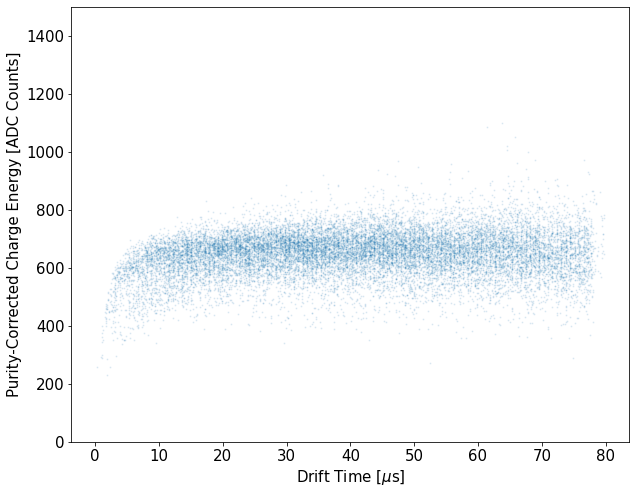

In [5]:
plt.scatter(DriftTime, df_sim['Purity-Corrected Charge Energy'], s=1, alpha=0.1)
plt.xlabel('Drift Time [$\mu$s]')
plt.ylabel('Purity-Corrected Charge Energy [ADC Counts]')
plt.ylim(0,1500)
plt.show()

In [6]:
for k in df_sim.keys():
    print(k)

ChannelPositions
ChannelTypes
Cluster Drift Time
Cluster Energies
Cluster X-Pos
Cluster Y-Pos
Cluster Z-Pos
Event
File
IsFull3D
NoiseIndex
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
Number3DClusters
NumberOfClusters
SiPM 1-1 Baseline
SiPM 1-1 Baseline RMS
SiPM 1-1 Induced Charge
SiPM 1-1 Pulse Area
SiPM 1-1 Pulse Height
SiPM 1-1 Pulse Time
SiPM 1-1 T10
SiPM 1-1 T20
SiPM 1-1 T5
SiPM 1-1 T80
SiPM 1-1 T90
SiPM 1-2 Baseline
SiPM 1-2 Baseline RMS
SiPM 1-2 Induced Charge
SiPM 1-2 Pulse Area
SiPM 1-2 Pulse Height
SiPM 1-2 Pulse Time
SiPM 1-2 T10
SiPM 1-2 T20
SiPM 1-2 T5
SiPM 1-2 T80
SiPM 1-2 T90
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Induced Charge
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
SiPM 1-4 Baseline
SiPM 1-4 Baseline RMS
SiPM 1-4 Induced Charge
SiPM 1-4 Pulse Area
SiPM 1-4 Pulse Height
SiPM 1-4 Pulse Time
SiPM 1-4 T10
SiPM 1-4 T20
SiPM 1-4 T5
SiPM 1-4 T80
Si

In [7]:
relative_energy = np.zeros(len(df_sim))
for ix in range(len(relative_energy)):
    relative_energy[ix] = max(df_sim['Cluster Energies'].iloc[ix])/df_sim['TotalTileEnergy'].iloc[ix]

In [8]:
sc_list = analysis_config.channel_map['ChannelName'][(analysis_config.channel_map['NumDevicesInChannel'] > 2) & (analysis_config.channel_map['ChannelType'] == 'TileStrip')]
mask_sc = np.ones(len(df_sim)).astype(bool)
for ch_name in sc_list:
    mask_sc = np.logical_and((df_sim['TileStrip %s Charge Energy'%ch_name]<2*df_sim['TileStrip %s Baseline RMS'%ch_name]),mask_sc)
print(sc_list)

10    Y1-10
25    X1-12
Name: ChannelName, dtype: object


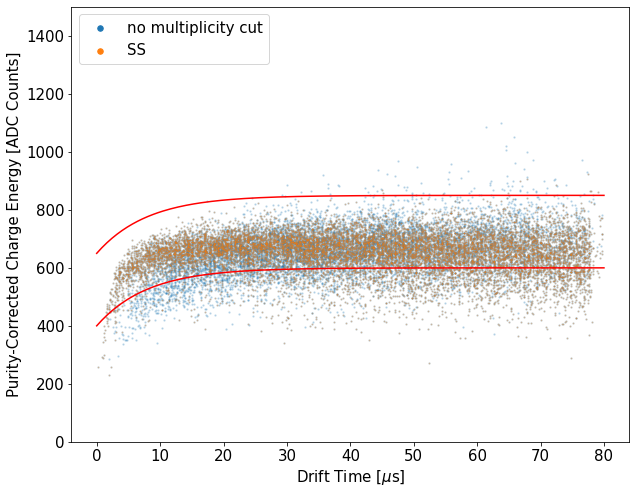

In [9]:
mask_SS = df_sim['NumberOfClusters'] == 1
alpha_band_charge = (df_sim['Purity-Corrected Charge Energy']>600-200*np.exp(-DriftTime/8)) &\
(df_sim['Purity-Corrected Charge Energy']<850-200*np.exp(-DriftTime/8))
alpha_band = alpha_band_charge
alpha_band_SS = alpha_band & mask_SS
alpha_band_SS_fully_recon = alpha_band_SS & df_sim['Number3DClusters'] == 1
x = np.linspace(0,80,200)
plt.scatter(DriftTime, df_sim['Purity-Corrected Charge Energy'], s=2, alpha=0.2,label='no multiplicity cut')
plt.scatter(DriftTime[mask_sc], df_sim['Purity-Corrected Charge Energy'][mask_sc], s=1, alpha=0.2,label='SS')
plt.plot(x,600-200*np.exp(-x/8),c='red')
plt.plot(x,850-200*np.exp(-x/8),c='red')
plt.xlabel('Drift Time [$\mu$s]')
plt.ylabel('Purity-Corrected Charge Energy [ADC Counts]')
plt.ylim(0,1500)
lgnd = plt.legend(loc="upper left")
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)
plt.show()

In [10]:
keys = df_sim.keys()
relative_energy_SS = np.zeros(sum(mask_sc))
for i,ix in enumerate(df_sim[mask_sc].index):
    mx = 0
    for k in keys:
        if ('Charge Energy' in k) and ('TileStrip' in k) and (df_sim[k][ix]>mx):
            mx = df_sim[k][ix]
    relative_energy_SS[i] = mx/df_sim['TotalTileEnergy'][ix]

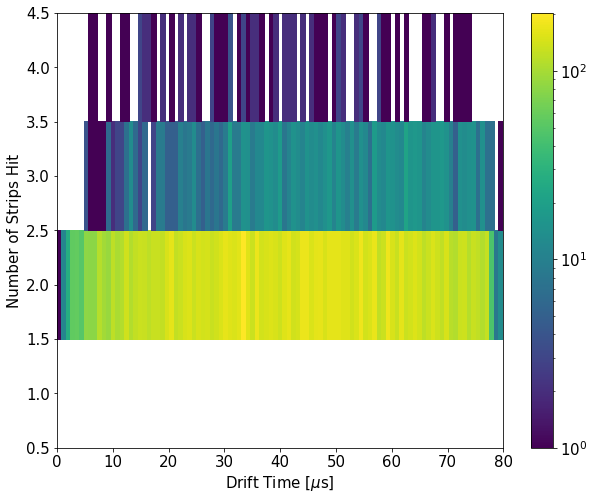

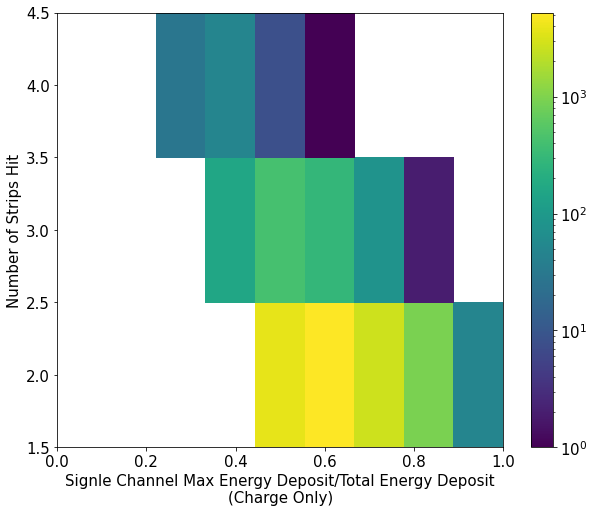

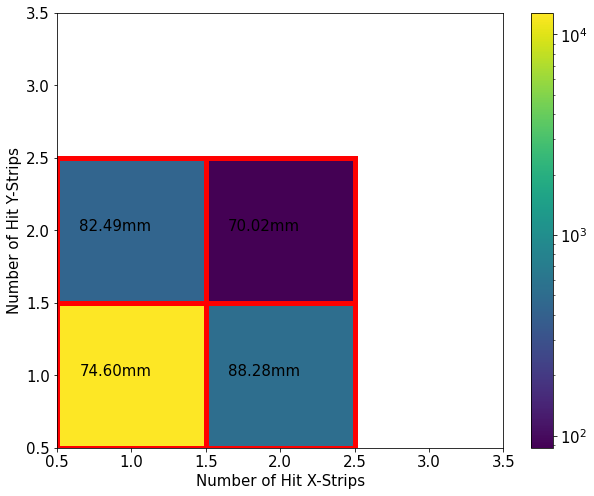

In [15]:
import matplotlib.colors as colors
plot1 = mask_sc
xlim = int(max(df_sim['NumberOfClusters'][plot1]))
#plt.hist2d(df_sim['NumberOfClusters'][plot1],\
#           relative_energy[plot1],bins=[np.linspace(0,xlim,xlim+1)+0.5,np.linspace(0,1,50)],norm=colors.LogNorm())
#plt.colorbar()
#plt.xlabel('Number Of Clusters')
#plt.ylabel('Highest Energy Cluster/Total Energy Deposit\n(Charge Energy)')
#plt.show()
plot3 = mask_sc
plot2 = mask_sc
xlim = int(max(df_sim['NumTileChannelsHit'][plot2]))
plt.hist2d(DriftTime[plot3][(relative_energy_SS>0) & (relative_energy_SS<1)],\
           df_sim['NumTileChannelsHit'][plot3][(relative_energy_SS>0) & (relative_energy_SS<1)],bins=[np.linspace(0,80,100),np.linspace(0,xlim,xlim+1)+0.5],\
           norm=colors.LogNorm())
#plt.ylim(1.5,5.5)
plt.colorbar()
plt.xlabel('Drift Time [$\mu$s]')
plt.ylabel('Number of Strips Hit')
plt.show()
#plt.hist(relative_energy_SS[(relative_energy_SS>0) & (relative_energy_SS<1)],bins=30,log=True)
#plt.xlabel('Signle Channel Max Energy Deposit/Total Energy Deposit\n(Charge Only)')
#plt.show()
plt.hist2d(relative_energy_SS[(relative_energy_SS>0) & (relative_energy_SS<1)],\
           df_sim['NumTileChannelsHit'][mask_sc][(relative_energy_SS>0) & (relative_energy_SS<1)],\
           bins=[np.linspace(0,1,10),[1.5,2.5,3.5,4.5]],
           norm=colors.LogNorm())
plt.xlabel('Signle Channel Max Energy Deposit/Total Energy Deposit\n(Charge Only)')
plt.ylabel('Number of Strips Hit')
plt.colorbar()
plt.show()
xlim = int(max(df_sim['NumXTileChannelsHit'][plot3]))
ylim = int(max(df_sim['NumYTileChannelsHit'][plot3]))
xlim = 4
ylim = 4
plt.hist2d(df_sim['NumXTileChannelsHit'][plot3],\
           df_sim['NumYTileChannelsHit'][plot3],bins=[np.linspace(-1,xlim,xlim+2)+0.5,np.linspace(-1,ylim,ylim+2)+0.5],\
           norm=colors.LogNorm())
plt.xlim(0.5,3.5)
plt.ylim(0.5,3.5)
plt.colorbar()
plt.xlabel('Number of Hit X-Strips')
plt.ylabel('Number of Hit Y-Strips')
for x,y in itertools.product(range(xlim+1),range(ylim+1)):
    msk = (df_sim['NumXTileChannelsHit'] == x) & (df_sim['NumYTileChannelsHit'] == y) & plot3
    val = '{:.2f}'.format(np.mean(DriftTime[msk]*analysis_config.run_parameters['Drift Velocity [mm/us]']))
    if val != 'nan':
        plt.text(x-0.35,y,val+'mm')
        if abs(x-y)<2:
            plt.gca().add_patch(Rectangle((x-0.5, y-0.5), 1, 1, fill=False, ec='red', lw=5))
plt.show()

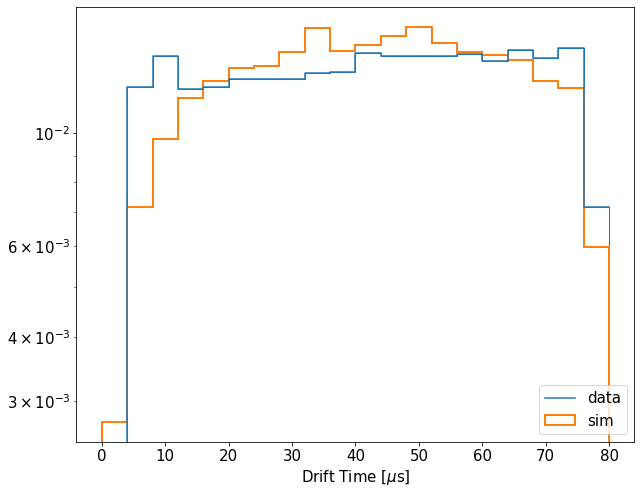

In [12]:
%store -r h_alpha_data
plt.step(h_alpha_data[1][1:],h_alpha_data[0],label='data')
plt.hist(DriftTime[mask_sc],bins=20,histtype='step',range=(0,80),density=True,label='sim',lw=2)
plt.xlabel('Drift Time [$\mu$s]')
plt.legend()
plt.yscale('log')

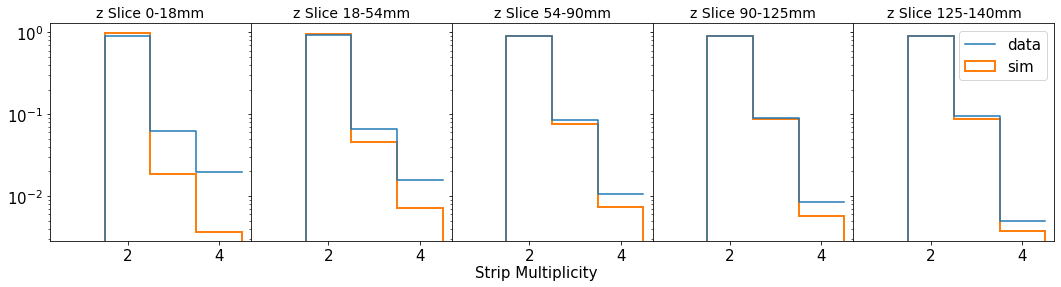

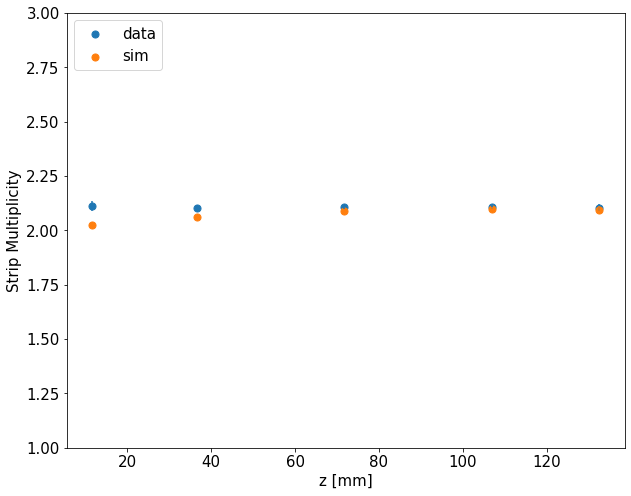

In [13]:
%store -r hist_export_alpha
%store -r val_export_alpha
%store -r err_export_alpha
%store -r z_err_export_alpha
min_time = 10
max_time = 70
time_slice_number = 4
drift_velocity = analysis_config.run_parameters['Drift Velocity [mm/us]']
z_slice = np.linspace(min_time,max_time,time_slice_number)*drift_velocity
fig1,ax1 = plt.subplots(1,time_slice_number+1,sharey=True,gridspec_kw={'wspace': 0,'hspace': 0})
z_bin_phys = np.digitize(DriftTime[plot3],z_slice)
z_bin_phys_sc = np.digitize(DriftTime[plot3][mask_sc],z_slice/drift_velocity)
fig1.set_size_inches(18,4)
ax1[0].set_yscale('log')
fig2 = plt.figure(2)
#fig2.set_size_inches(6,5)
for ds in range(time_slice_number+1):
    if ds == 0:
        title1 = 0
        title2 = z_slice[ds]
    elif ds == time_slice_number:
        title1 = z_slice[ds-1]
        title2 = 140
    else:
        title1 = z_slice[ds-1]
        title2 = z_slice[ds]
    plt.figure(fig1.number)
    ax1[ds].set_title('z Slice {:.0f}-{:.0f}mm'.format(title1,title2), fontsize=14)
    if ds == time_slice_number:
        ax1[ds].step(hist_export_alpha[ds][1][1:],hist_export_alpha[ds][0],label='data')
        ax1[ds].hist(df_sim['NumTileChannelsHit'][plot3][mask_sc][z_bin_phys_sc==ds],\
                     bins=[0.5,1.5,2.5,3.5,4.5],label='sim',histtype='step',density=True,lw=2)
        plt.legend()
    else:
        ax1[ds].step(hist_export_alpha[ds][1][1:],hist_export_alpha[ds][0])
        ax1[ds].hist(df_sim['NumTileChannelsHit'][plot3][mask_sc][z_bin_phys_sc==ds],\
                     bins=[0.5,1.5,2.5,3.5,4.5],histtype='step',density=True,lw=2)
    #mean = np.mean(df_sim['NumTileChannelsHit'][plot3][z_bin_phys==ds])
    #std = np.std(df_sim['NumTileChannelsHit'][plot3][z_bin_phys==ds])
    #z_mean = np.mean(DriftTime[plot3][z_bin_phys==ds])
    #z_std = np.std(DriftTime[plot3][z_bin_phys==ds])
    mean_sc = np.mean(df_sim['NumTileChannelsHit'][plot3][mask_sc][z_bin_phys_sc==ds])
    std_sc = np.std(df_sim['NumTileChannelsHit'][plot3][mask_sc][z_bin_phys_sc==ds])/np.sqrt(sum(z_bin_phys_sc==ds))
    z_mean_sc = np.mean(DriftTime[plot3][mask_sc][z_bin_phys_sc==ds])
    z_std_sc = np.std(DriftTime[plot3][mask_sc][z_bin_phys_sc==ds])/np.sqrt(sum(z_bin_phys_sc==ds))
    plt.figure(fig2.number)
    if ds == time_slice_number:
        plt.scatter(z_mean_sc*drift_velocity,val_export_alpha[ds],s=50,label='data',c='C0')
        plt.errorbar(z_mean_sc*drift_velocity,val_export_alpha[ds],\
                     2*err_export_alpha[ds],z_err_export_alpha[ds]*drift_velocity,c='C0')
        plt.scatter(z_mean_sc*drift_velocity,mean_sc,s=50,label='sim',c='C1')
        plt.errorbar(z_mean_sc*drift_velocity,mean_sc,2*std_sc,z_std_sc,c='C1')
        plt.legend(loc=2)
    else:
        plt.scatter(z_mean_sc*drift_velocity,val_export_alpha[ds],s=50,c='C0')
        plt.errorbar(z_mean_sc*drift_velocity,val_export_alpha[ds],\
                     2*err_export_alpha[ds],z_err_export_alpha[ds]*drift_velocity,c='C0')
        plt.scatter(z_mean_sc*drift_velocity,mean_sc,s=50,c='C1')
        plt.errorbar(z_mean_sc*drift_velocity,mean_sc,2*std_sc,z_std_sc,c='C1')
plt.xlabel('z [mm]')
plt.ylabel('Strip Multiplicity')
plt.ylim(1,3)
fig1.text(0.5, 0, 'Strip Multiplicity', ha='center')
plt.show()

Text(0.5, 0, 'Purity-Corrected Charge Energy [ADCU]')

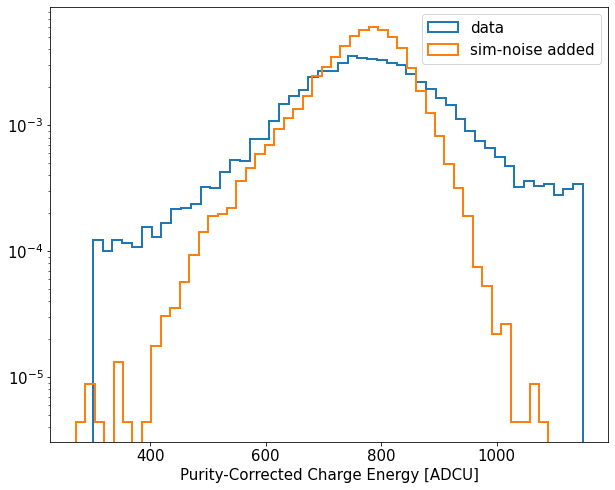

In [19]:
%store -r alpha_charge_sp
plt.hist(alpha_charge_sp,bins=50,histtype='step',\
         log=True,density=True,label='data',lw=2)
plt.hist(df_sim['Purity-Corrected Charge Energy'][mask_sc]*1.18,bins=50,histtype='step',\
         log=True,density=True,label='sim-noise added',lw=2)
#plt.vlines(700,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1])
plt.legend()
plt.xlabel('Purity-Corrected Charge Energy [ADCU]')

In [44]:
energy_min = 200
energy_max  = 7000
t_min = 5
t_max = 75
df_ind = df.iloc[alpha_band_SS_fully_recon]
DriftTime_ind = DriftTime.iloc[alpha_band_SS_fully_recon]

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


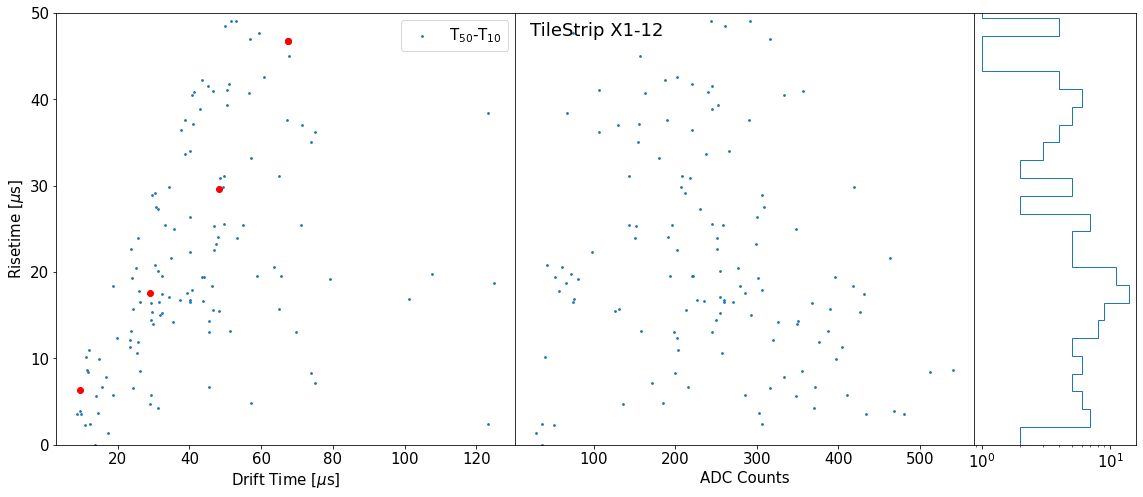

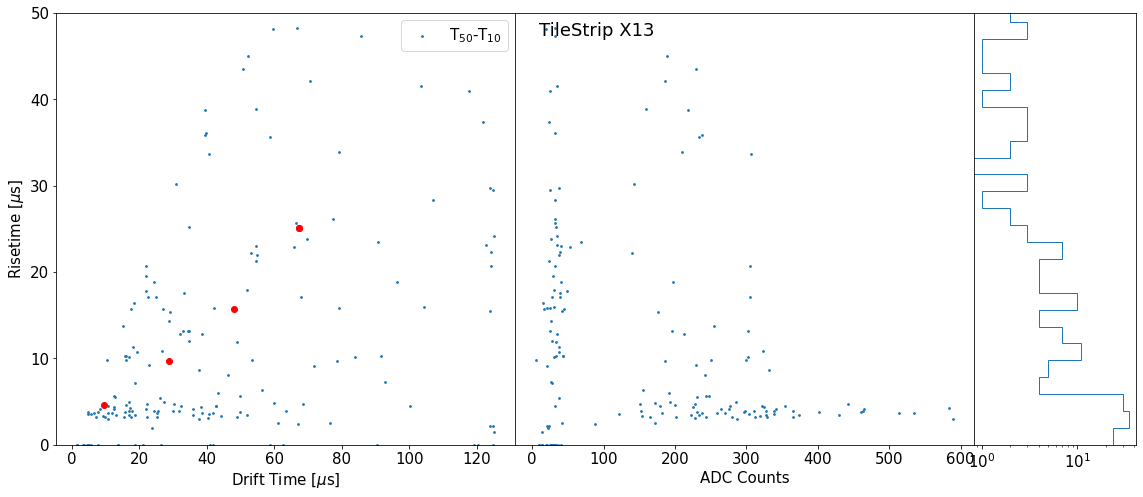

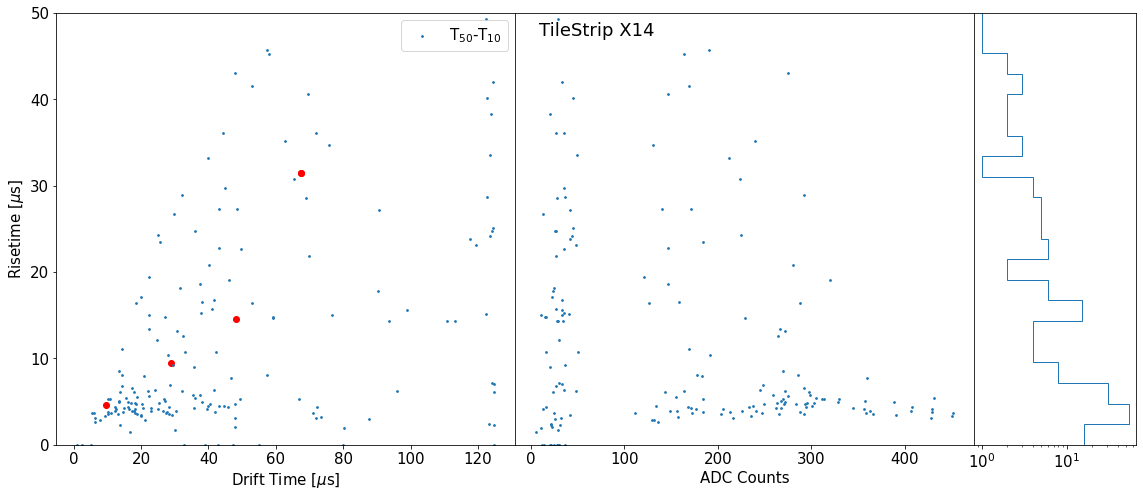

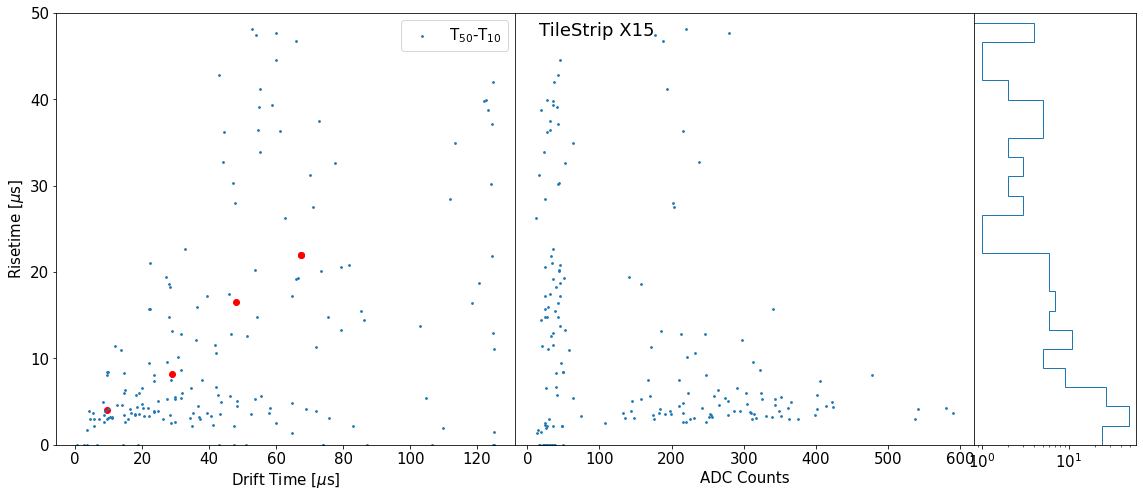

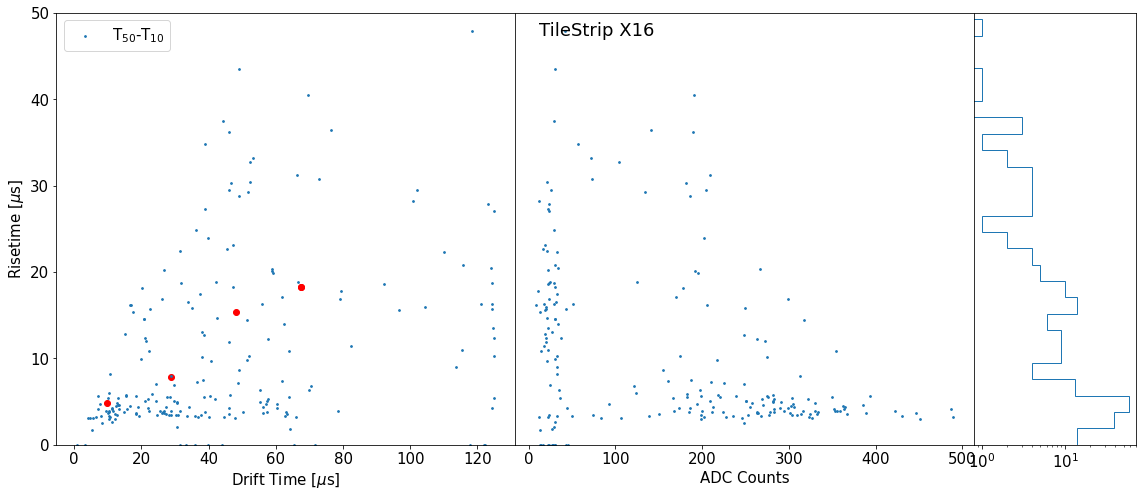

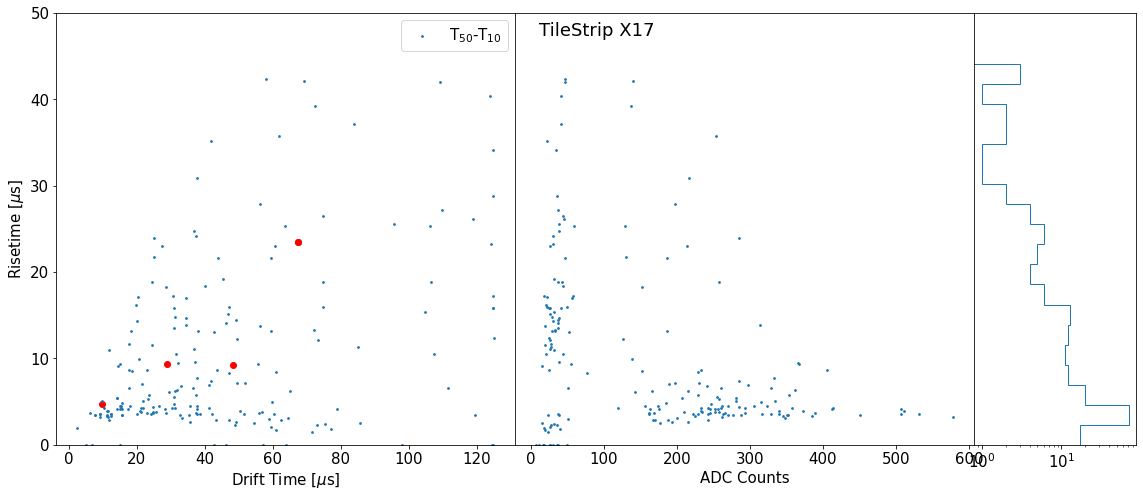

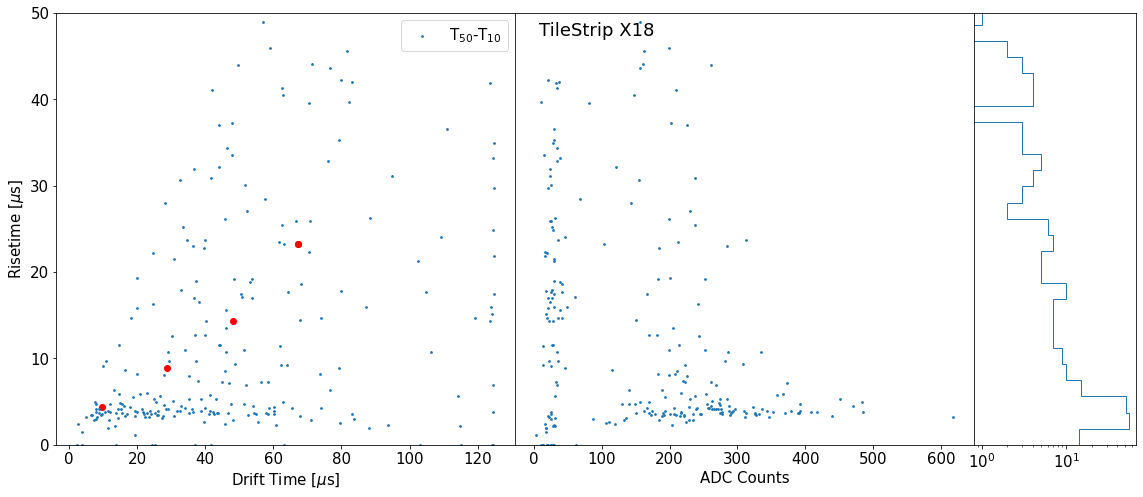

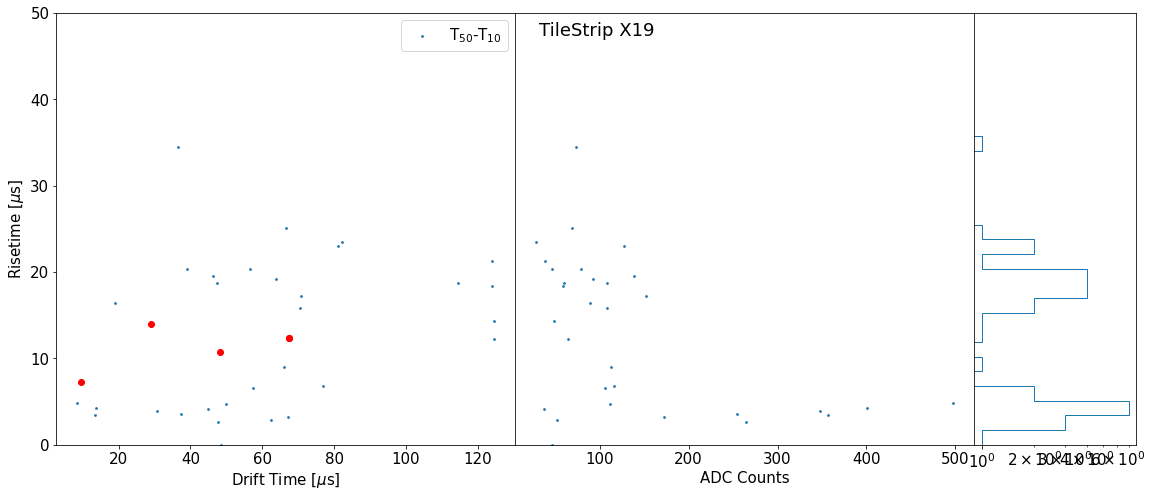

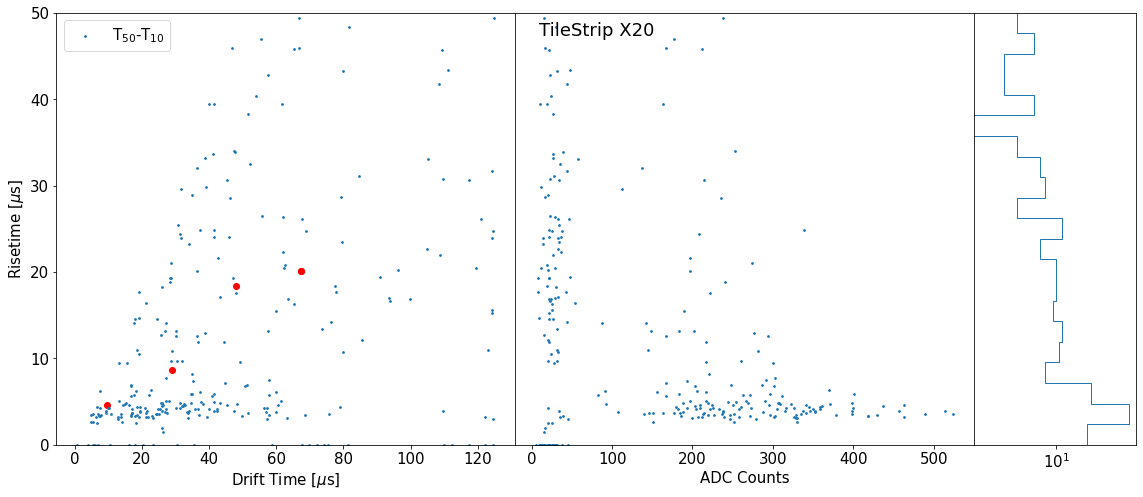

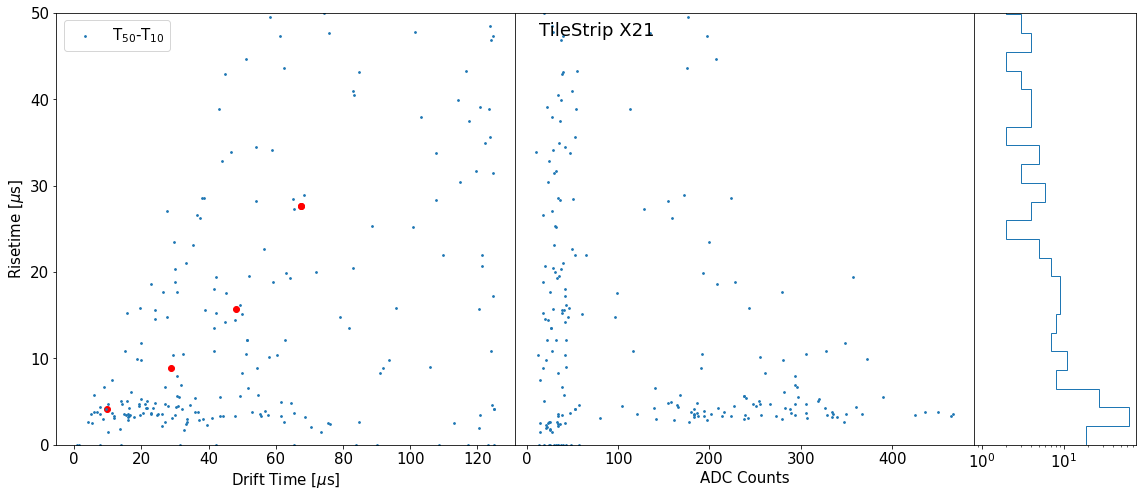

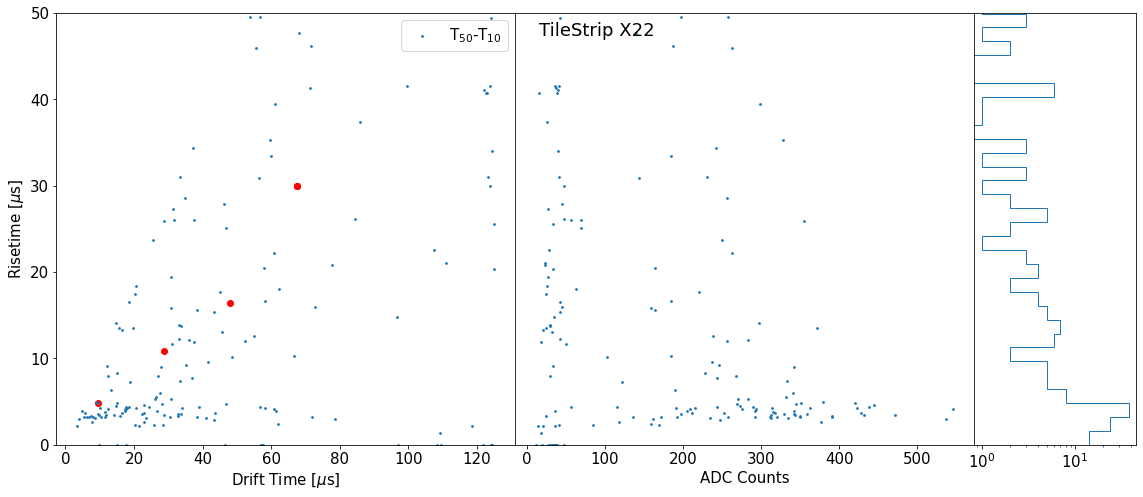

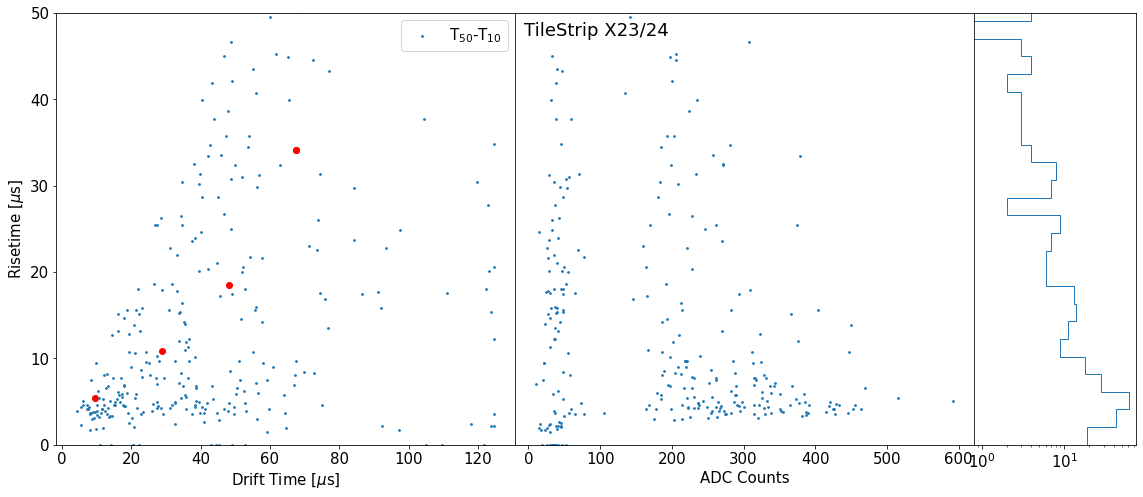

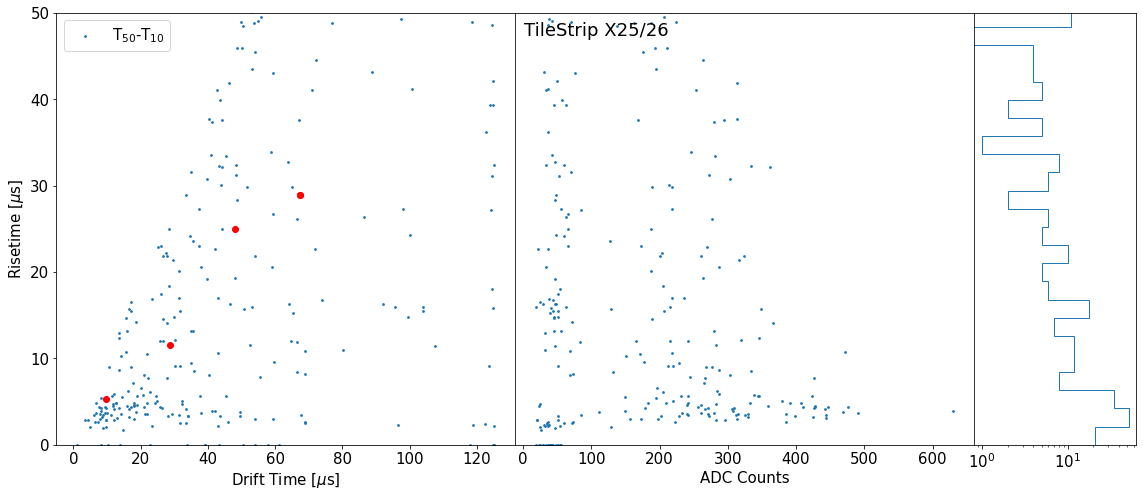

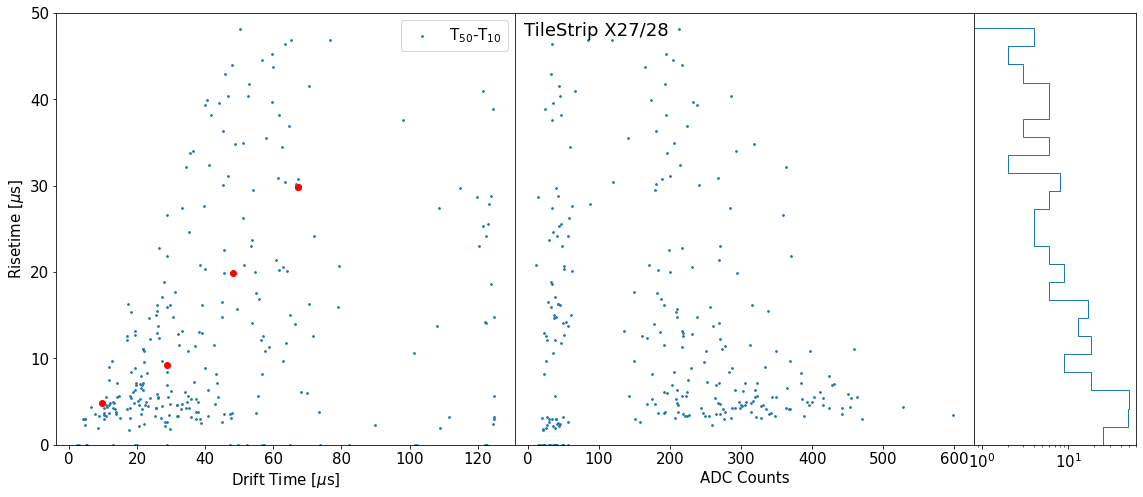

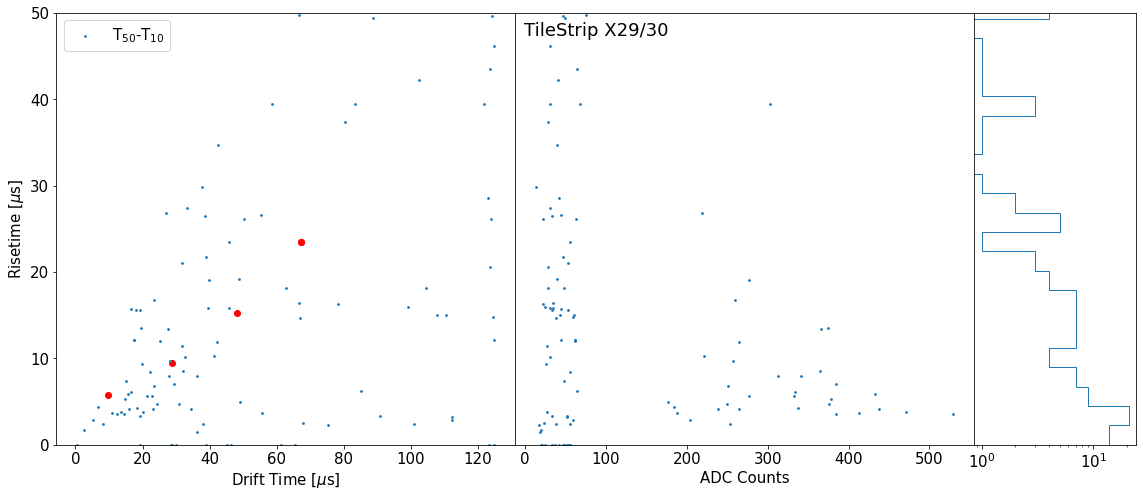

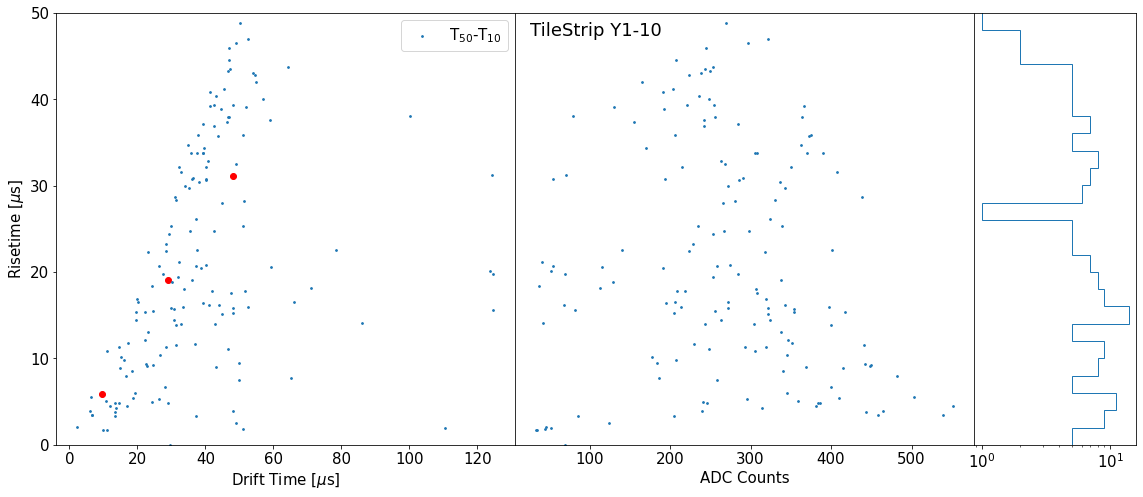

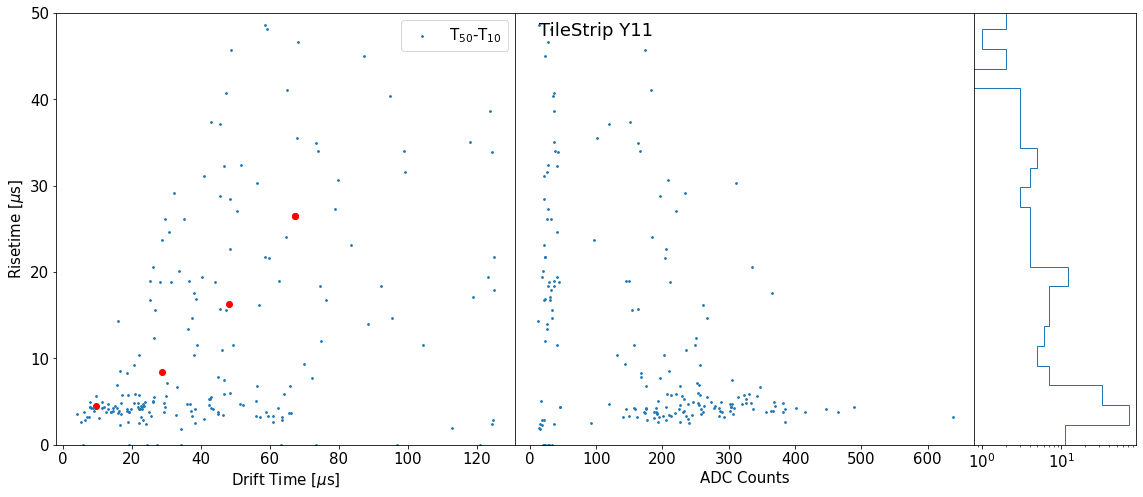

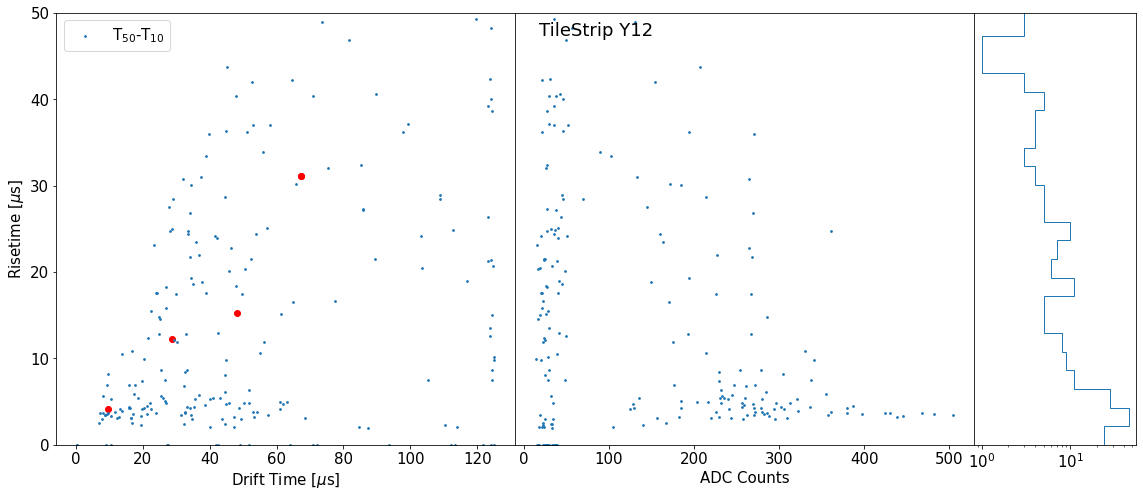

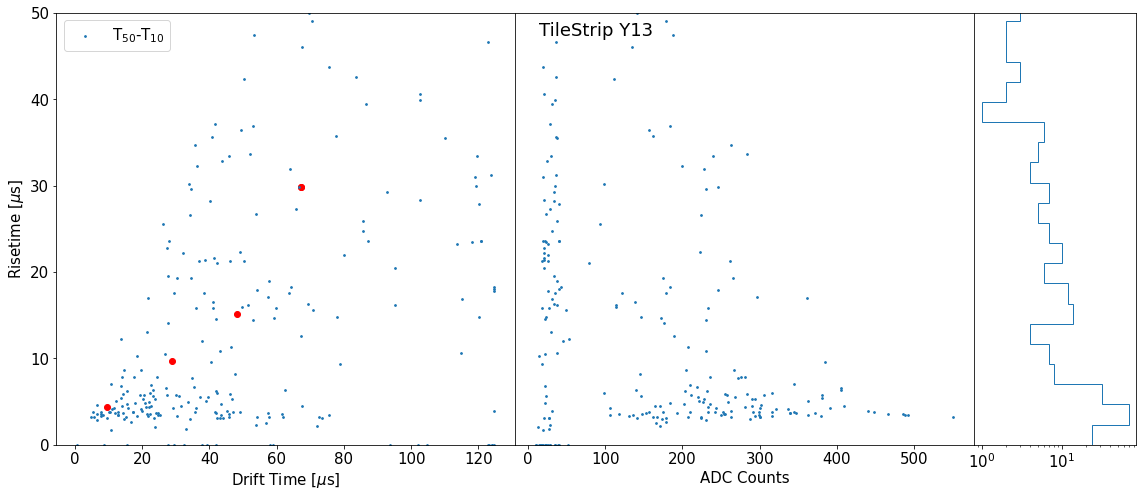

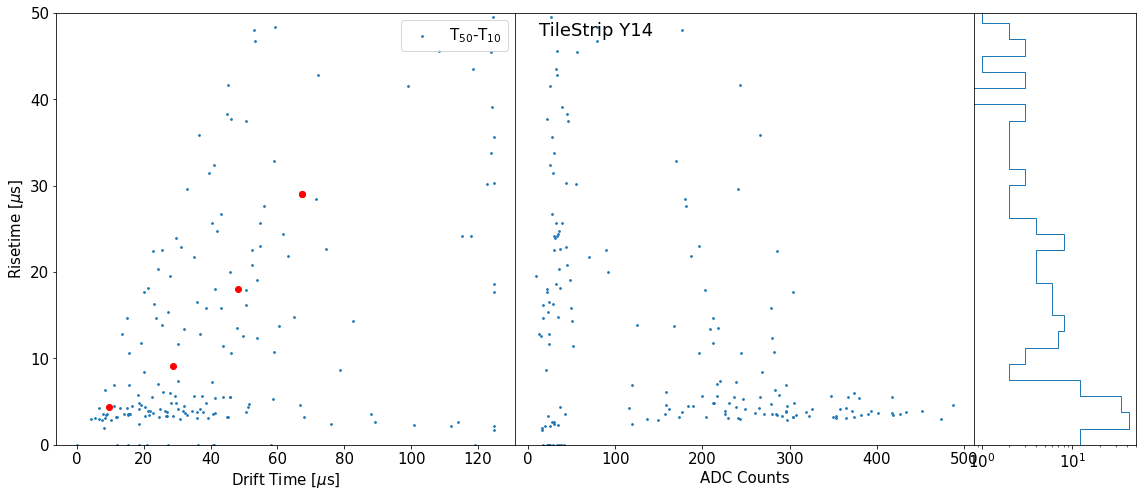

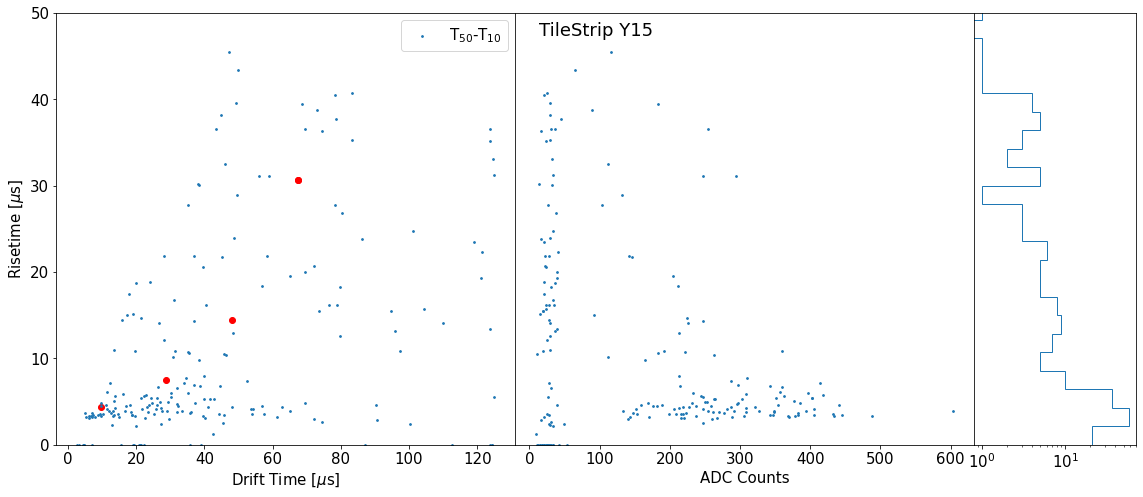

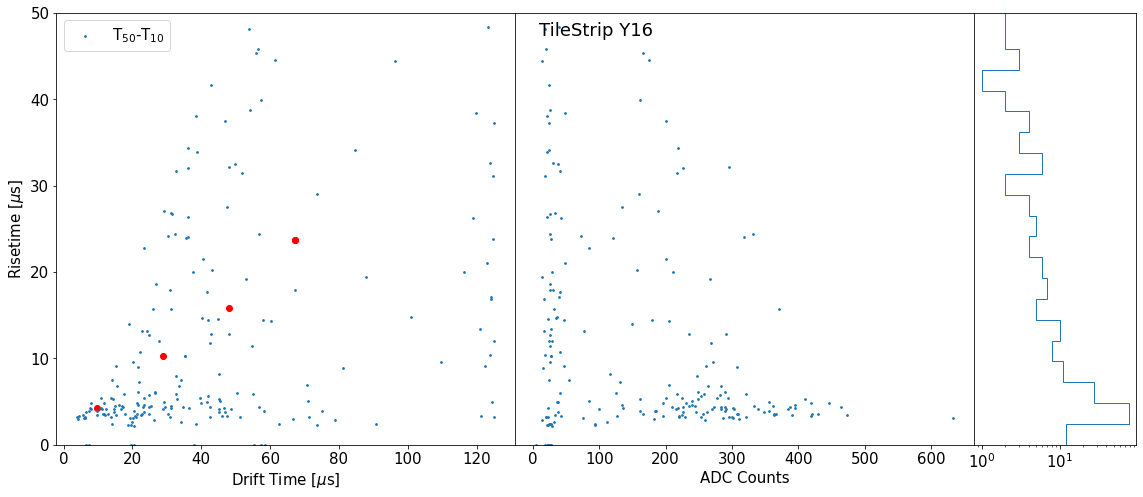

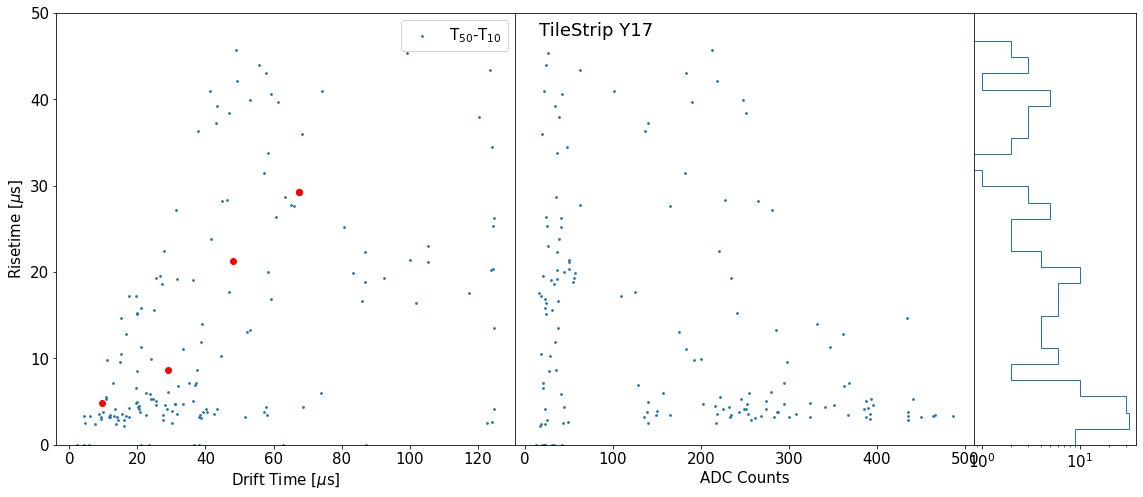

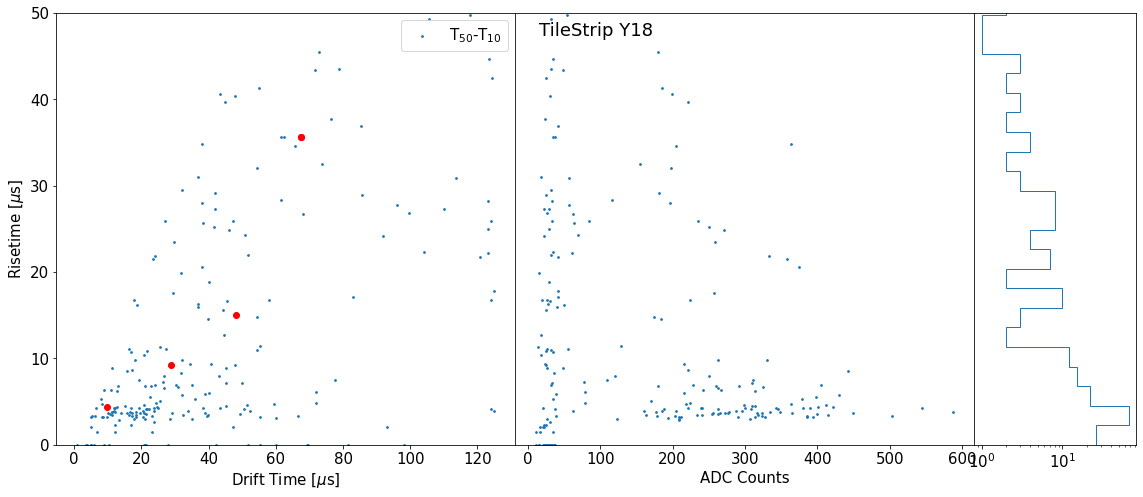

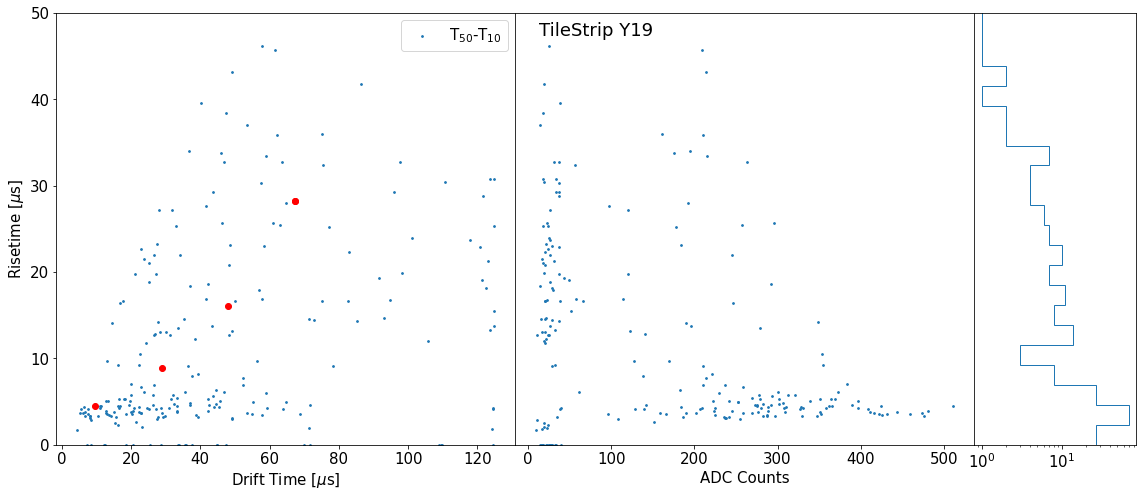

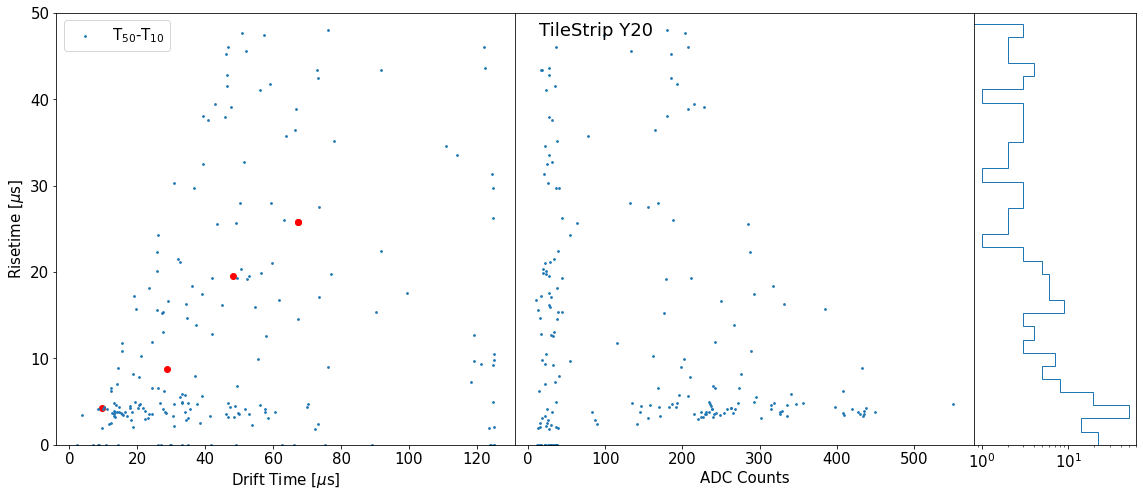

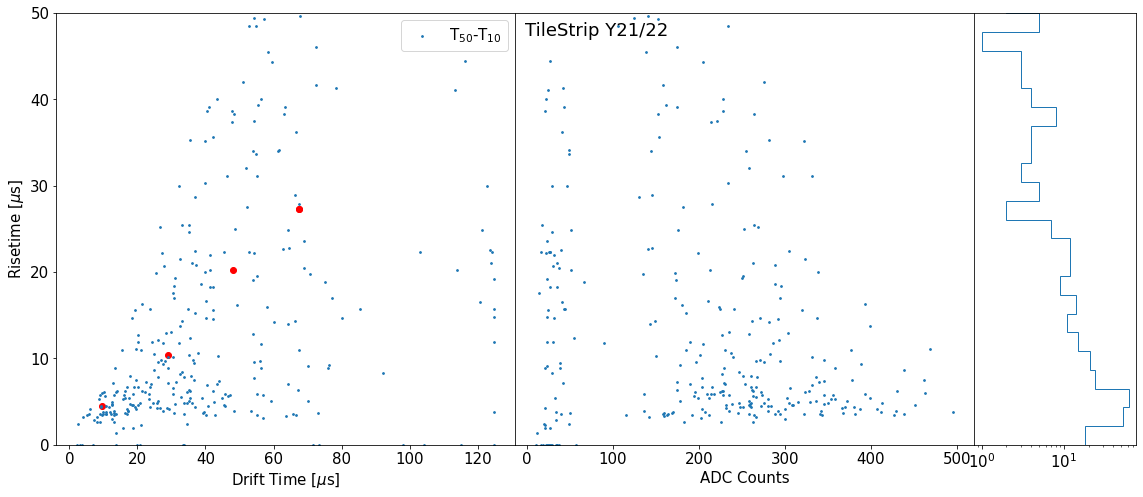

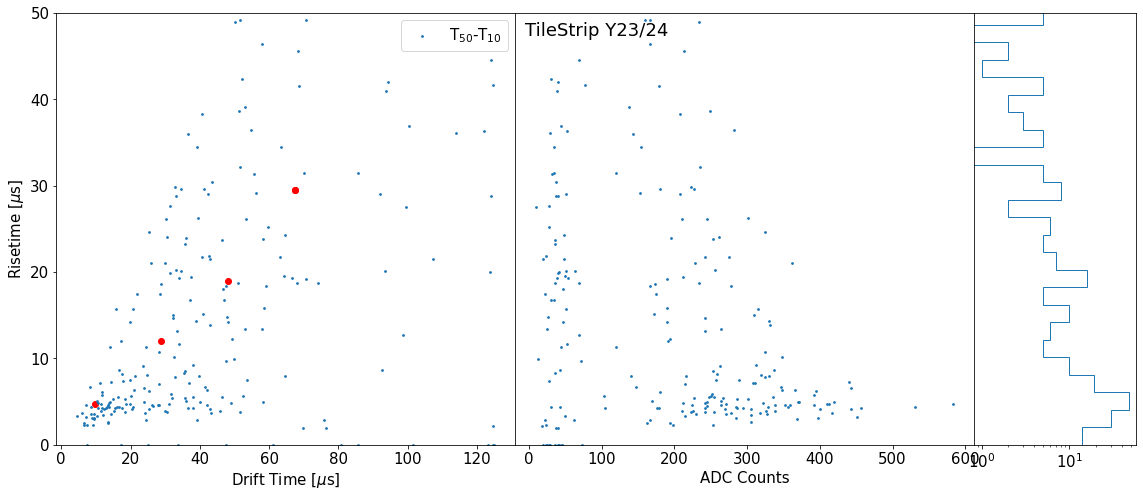

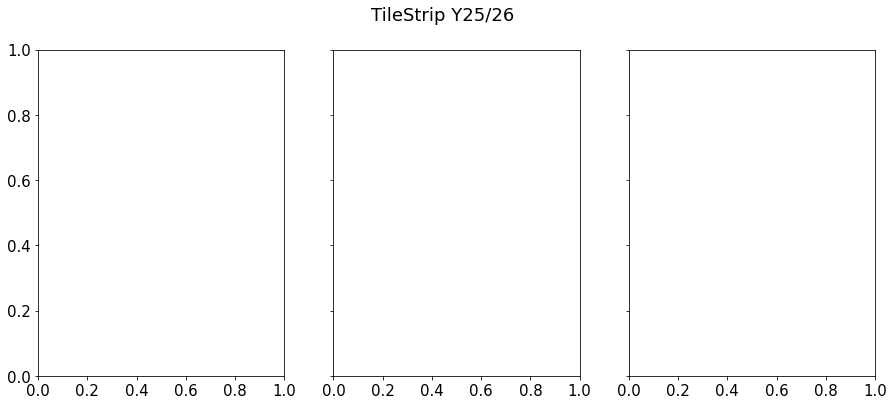

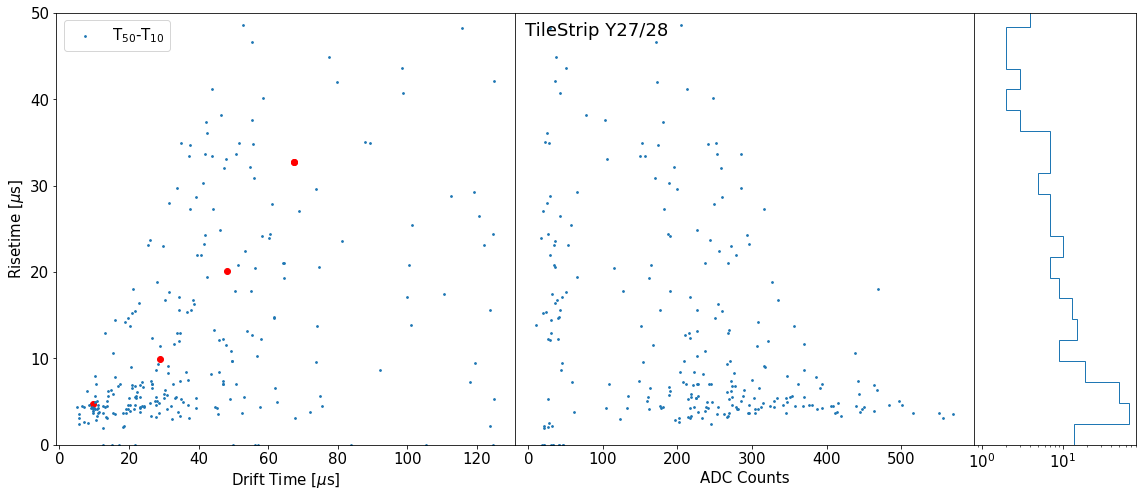

In [18]:
i = 0
bins = 50
analysis_config.GetCalibrationConstantsFromFile('/g/g90/jacopod/software/TMSAnalysis/config/30th/Calibrations_Xe_Run30.csv')
for k in df_ind.keys():
    if not (k.startswith('TileStrip') and k.endswith('Charge Energy')):
        continue
    fig,ax = plt.subplots(1,3,figsize=(15,6),sharey=True)
    ch_name = analysis_config.calibration_constants.index[i]
    ch = 'TileStrip ' + ch_name
    i += 1
    fig.suptitle(ch)
    try:
        #mask = (df_ind[ch + ' Charge Energy']>energy_min) & (df_ind[ch + ' Charge Energy']<energy_max) &\
        #((df_ind[ch + ' T50'] - df_ind[ch + ' T10'])*sampling_time<df_ind[ch + ' Drift Time'])
        mask = ((df_ind[ch + ' T50'] - df_ind[ch + ' T10'])*sampling_time<df_ind[ch + ' Drift Time'])
    except KeyError:
        continue
    rise_time10 = (df_ind[ch + ' T90'][mask] - df_ind[ch + ' T10'][mask])*sampling_time
    rise_time25 = (df_ind[ch + ' T90'][mask] - df_ind[ch + ' T25'][mask])*sampling_time
    rise_time50 = (df_ind[ch + ' T90'][mask] - df_ind[ch + ' T50'][mask])*sampling_time
    rise_time1025 = (df_ind[ch + ' T25'][mask] - df_ind[ch + ' T10'][mask])*sampling_time
    rise_time2550 = (df_ind[ch + ' T50'][mask] - df_ind[ch + ' T25'][mask])*sampling_time
    rise_time5090 = (df_ind[ch + ' T90'][mask] - df_ind[ch + ' T50'][mask])*sampling_time
    rise_time1050 = (df_ind[ch + ' T50'][mask] - df_ind[ch + ' T10'][mask])*sampling_time
    ch_drift_time = df_ind[ch + ' Drift Time'][mask]
    dt_slice = np.linspace(0,77,5)
    for j,e in enumerate(dt_slice):
        if j < (len(dt_slice)-1):
            mask_slice = (ch_drift_time>e) & (ch_drift_time<dt_slice[j+1])
            dt_val = (dt_slice[j+1]+e)/2
        ax[0].scatter(dt_val,np.mean(rise_time1050[mask_slice]),c='red')
    ax[0].set_ylim(0,50)
    #ax[0].scatter(ch_drift_time,rise_time10,s=3,alpha=1,label = 'T$_{90}$-T$_{10}$')
    #ax[0].scatter(ch_drift_time,rise_time25,s=3,alpha=1,label = 'T$_{90}$-T$_{25}$')
    #ax[0].scatter(ch_drift_time,rise_time50,s=3,alpha=1,label = 'T$_{90}$-T$_{50}$')
    ax[0].scatter(ch_drift_time,rise_time1050,s=3,alpha=1,label = 'T$_{50}$-T$_{10}$')
    ax[0].set_xlabel('Drift Time [$\mu$s]')
    ax[0].set_ylabel('Risetime [$\mu$s]')
    ax[0].set_position([0,0,0.425,1])
    #ax[1].scatter(df_ind[ch + ' Charge Energy'][mask],rise_time10,s=3,alpha=1,label = 'T$_{90}$-T$_{10}$')
    #ax[1].scatter(df_ind[ch + ' Charge Energy'][mask],rise_time25,s=3,alpha=1,label = 'T$_{90}$-T$_{25}$')
    #ax[1].scatter(df_ind[ch + ' Charge Energy'][mask],rise_time50,s=3,alpha=1,label = 'T$_{90}$-T$_{50}$')
    ax[1].scatter(df_ind[ch + ' Charge Energy'][mask],rise_time1050,s=3,alpha=1,label = 'T$_{90}$-T$_{50}$')
    ax[1].get_yaxis().set_visible(False)
    ax[1].set_xlabel('ADC Counts')
    ax[1].set_position([0.425,0,0.425,1])
    ax[2].set_position([0.85,0,0.15,1])
    #ax[2].hist(rise_time10, orientation='horizontal', bins = bins, histtype='step',log=True)
    #ax[2].hist(rise_time25, orientation='horizontal', bins = bins, histtype='step',log=True)
    #ax[2].hist(rise_time50, orientation='horizontal', bins = bins, histtype='step',log=True)
    ax[2].hist(rise_time1050, orientation='horizontal', bins = bins, histtype='step',log=True)
    ax[2].get_yaxis().set_visible(False)
    ax[0].legend()
    plt.show()

0.2504026426702625
0.8914593330273632
2.0795386089524808
3.292044885552455
4.827237732438009
10.890793696265423


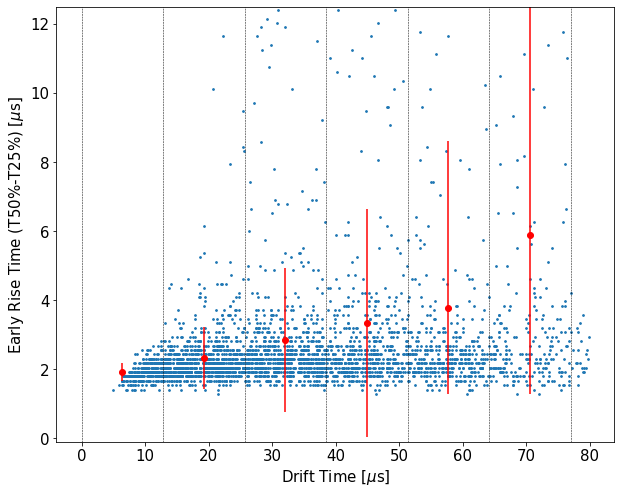

In [55]:
rise_time1050 = []
dt_channel = []
for ch in analysis_config.channel_map['ChannelName'][analysis_config.channel_map['ChannelType'] == 'TileStrip']:
    #if ('-' in ch) or ('/' in ch):
    #if '-' in ch:
    #    continue
    energy_key = 'TileStrip ' + ch + ' Charge Energy'
    rms_key = 'TileStrip ' + ch + ' Baseline RMS'
    channel_mask = (df_ind[energy_key] > 5*df_ind[rms_key]) &\
    (df_ind['TileStrip '+ch+' T10'] > trigger_time) &\
    (df_ind[energy_key]>0.5)
    rise_time1050.append((df_ind['TileStrip '+ch+' T50'][channel_mask] - df_ind['TileStrip '+ch+' T25'][channel_mask])*\
    sampling_time)
    dt_channel.append(DriftTime_ind[channel_mask])
rise_time1050 = pd.concat(rise_time1050,ignore_index=True)
dt_channel = pd.concat(dt_channel,ignore_index=True)
plt.scatter(dt_channel,rise_time1050,s=3,alpha=1,label = 'T$_{50}$-T$_{10}$')
dt_slice = np.linspace(0,77,7)
for j,e in enumerate(dt_slice):
    try:
        mask_slice = (dt_channel>e) & (dt_channel<dt_slice[j+1])
        dt_val = (dt_slice[j+1]+e)/2
    except IndexError:
        continue
    val = np.mean(rise_time1050[mask_slice])
    std = np.std(rise_time1050[mask_slice])
    if std < val:
        low_err = std
    else:
        low_err = val - min(rise_time1050[mask_slice])   
    plt.errorbar(dt_val,val,[[low_err],[std]],fmt='none',c='red')
    plt.scatter(dt_val,val,c='red')
plt.xlabel('Drift Time [$\mu$s]')
plt.ylabel('Early Rise Time (T50%-T25%) [$\mu$s]')
plt.ylim(-0.1,12.5)
plt.vlines(dt_slice,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],linestyles='dashed',linewidth=0.5)

In [14]:
selection_index = df[(df['NumberOfClusters'] > 1) & (df['Purity-Corrected Charge Energy'] > 800)].index
print('selection cut: {} events'.format(len(selection_index)))

selection cut: 0 events


/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


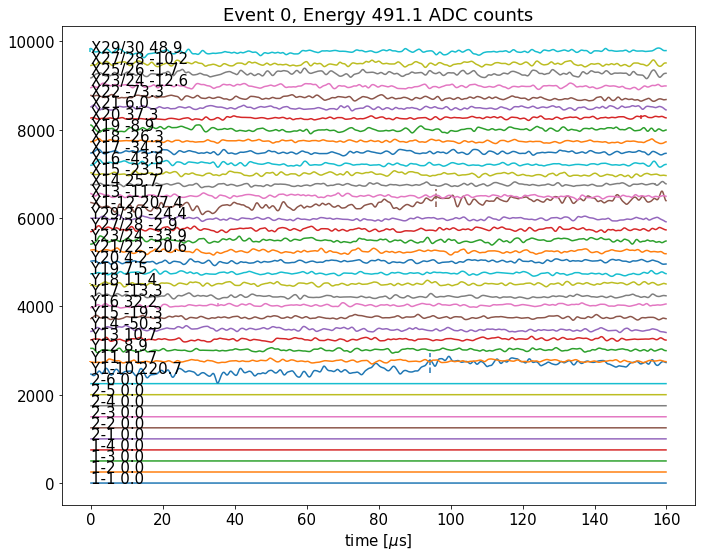

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


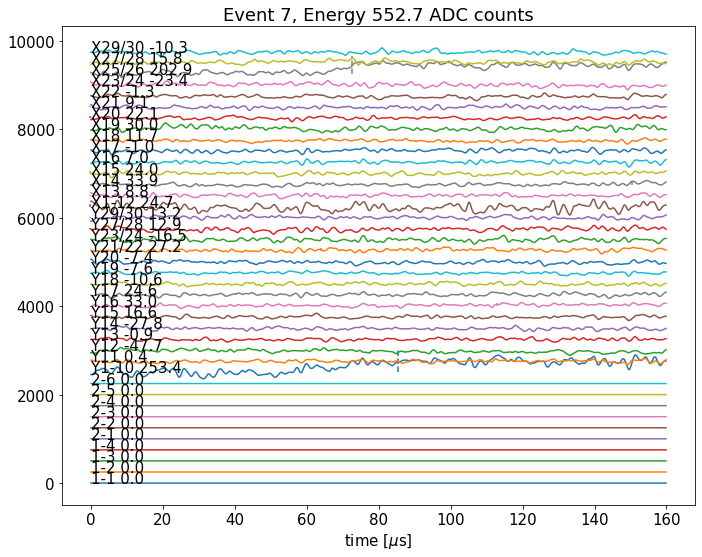

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


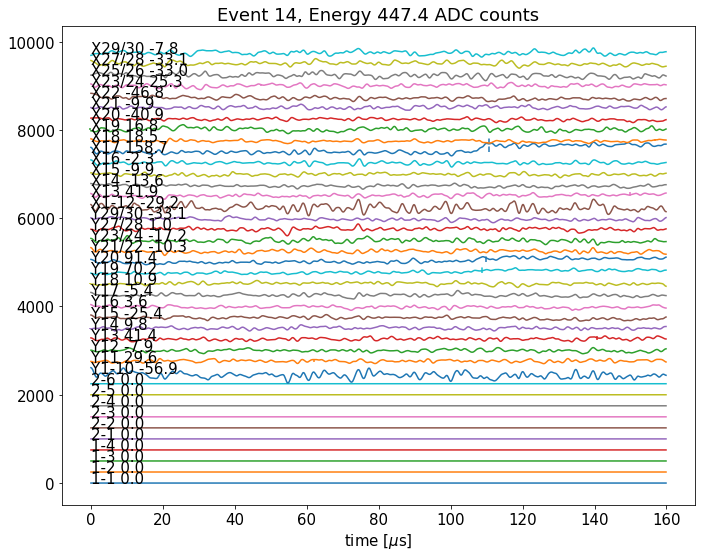

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


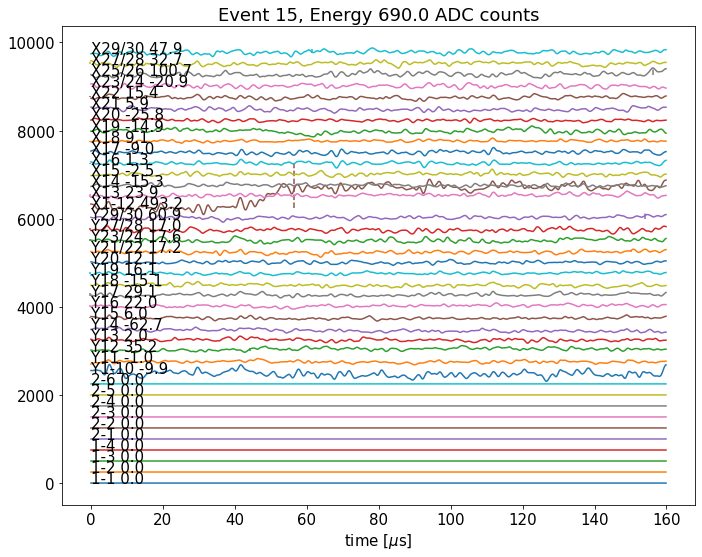

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


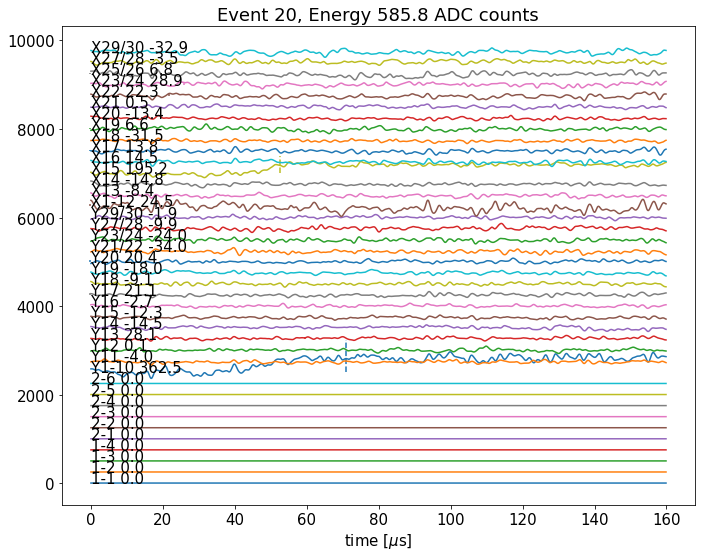

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


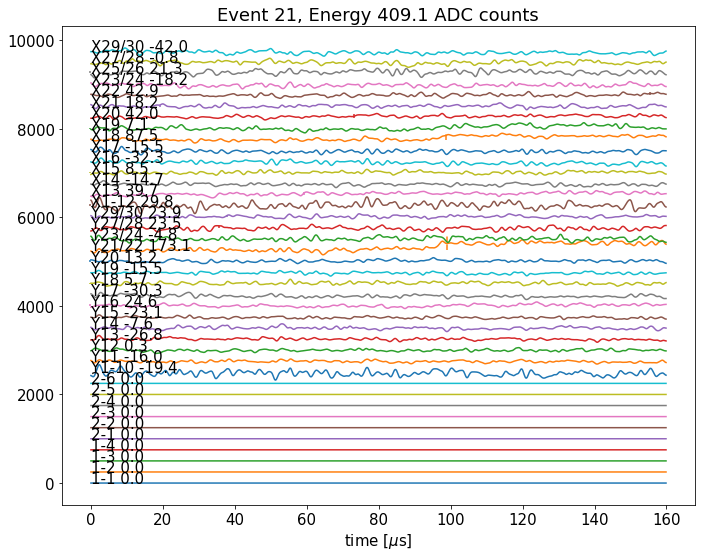

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


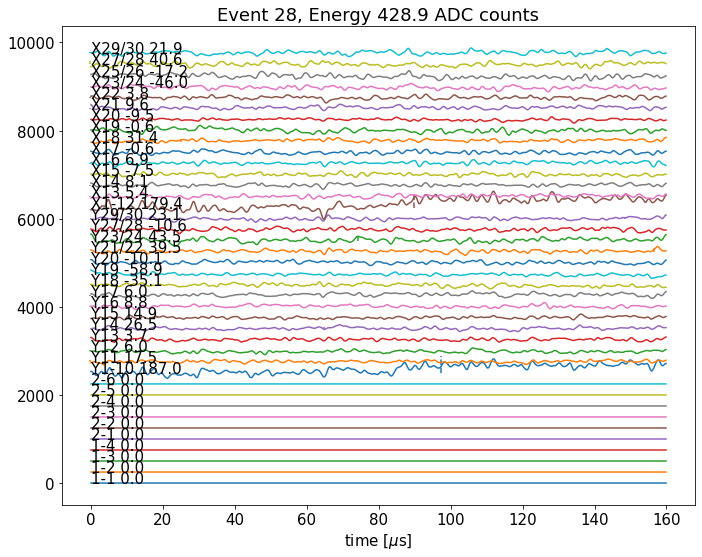

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


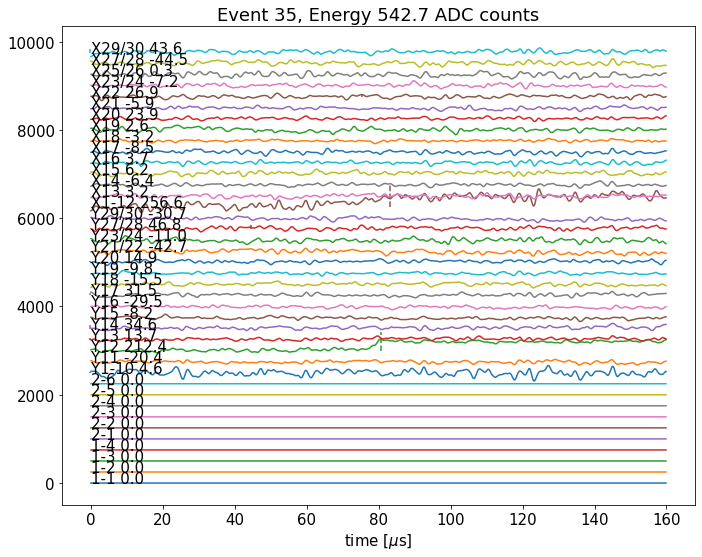

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


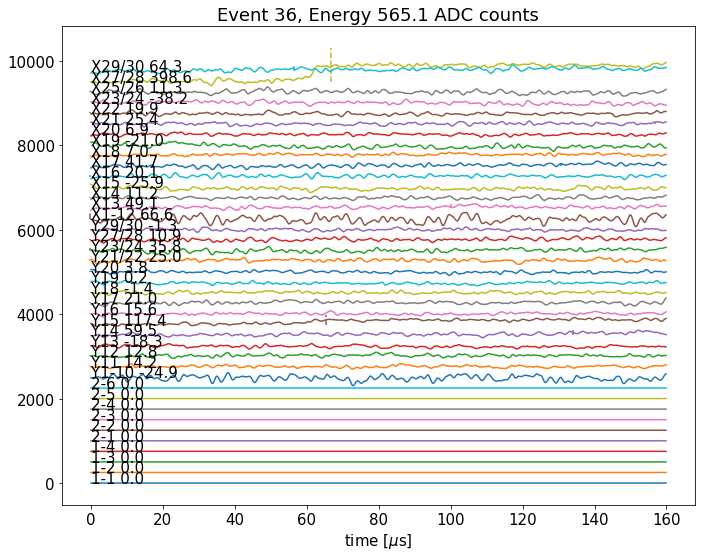

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


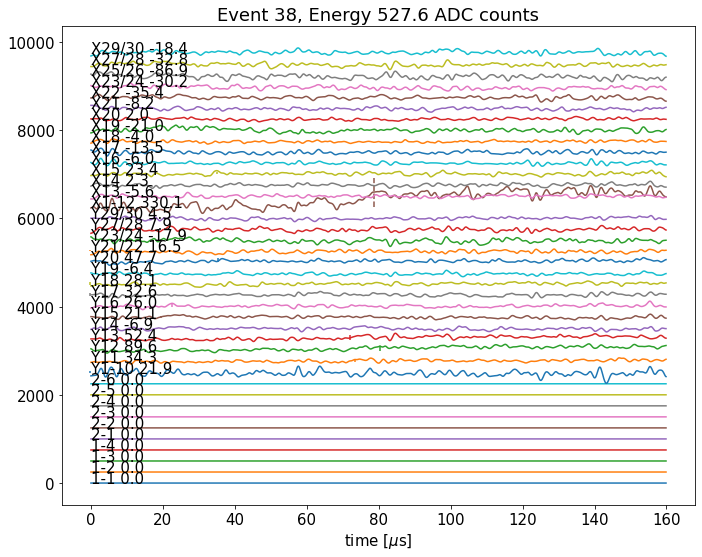

In [74]:
run_parameters_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Run_Parameters_Run30.xlsx'
calibrations_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Calibrations_Xe_Run30.csv'
channel_map_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Channel_Map_Run30.xlsx'
for i in selection_index[:10]:
    event = Waveform.Simulated_Event('/p/lustre1/jacopod/30th/20201207_alpha_sim/with_noise_500ns/reduced_added.p',\
                                     '/p/lustre1/lenardo1/stanford_teststand/simulations/Dec7_2020_alphas6207keV/',\
                                     i,\
                                     run_parameters_file,\
                                     calibrations_file,\
                                     channel_map_file,\
                                     add_noise=True)
    event.smooth(0.5)
    plot = event.plot_event(True)
    plot.show()

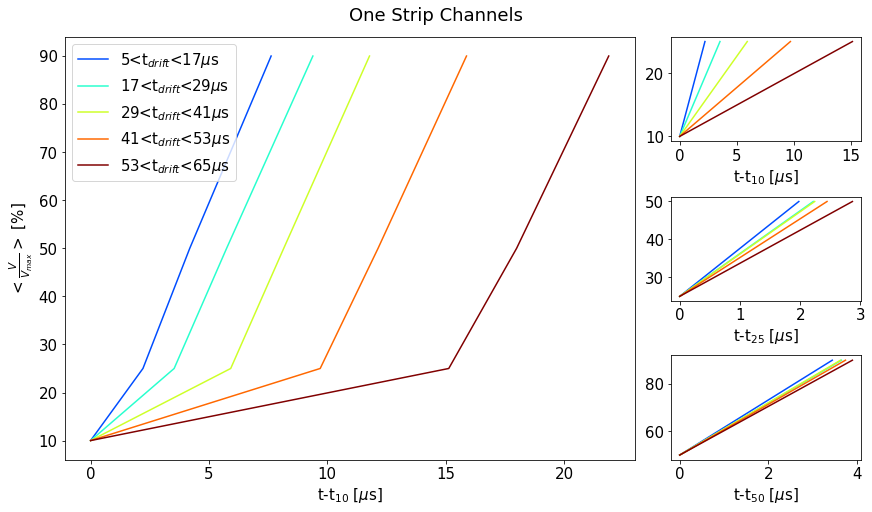

In [75]:
rise_time1025 = []
rise_time2550 = []
rise_time5090 = []
ix_list = []
for ch in analysis_config.channel_map['ChannelName'][analysis_config.channel_map['ChannelType'] == 'TileStrip']:
    if ('-' in ch) or ('/' in ch):
    #if '-' in ch:
        continue
    energy_key = 'TileStrip ' + ch + ' Charge Energy'
    rms_key = 'TileStrip ' + ch + ' Baseline RMS'
    channel_mask = (df_ind[energy_key] > 5*df_ind[rms_key]) &\
    (df_ind['TileStrip '+ch+' T10'] > trigger_time) &\
    (df_ind[energy_key]>0.5)
    rise_time1025.append((df_ind['TileStrip '+ch+' T25'][channel_mask] - df_ind['TileStrip '+ch+' T10'][channel_mask])*\
    sampling_time)
    rise_time2550.append((df_ind['TileStrip '+ch+' T50'][channel_mask] - df_ind['TileStrip '+ch+' T25'][channel_mask])*\
    sampling_time)
    rise_time5090.append((df_ind['TileStrip '+ch+' T90'][channel_mask] - df_ind['TileStrip '+ch+' T50'][channel_mask])*\
    sampling_time)
    ix_list.extend(df_ind[channel_mask].index)
rise_time1025 = pd.concat(rise_time1025,ignore_index=True)
rise_time2550 = pd.concat(rise_time2550,ignore_index=True)
rise_time5090 = pd.concat(rise_time5090,ignore_index=True)

t_slice = 6
drift_range = np.linspace(5,65,t_slice)
fig3 = plt.figure(constrained_layout=True,figsize=(12,7))
gs = fig3.add_gridspec(3, 4)
f3_ax0 = fig3.add_subplot(gs[:, :-1])
f3_ax1 = fig3.add_subplot(gs[0, -1])
f3_ax2 = fig3.add_subplot(gs[1, -1])
f3_ax3 = fig3.add_subplot(gs[2, -1])
colors = plt.cm.jet(np.linspace(0,1,t_slice))
for j,dr in enumerate(drift_range):
    if j == 0:
        continue
    time_slice = np.logical_and(DriftTime_ind[ix_list]>drift_range[j-1],DriftTime_ind[ix_list]<dr)
    y_val = [10.0,25.0,50.0,90.0]
    x_val = [0]
    for v in (rise_time1025[time_slice.to_list()],\
              rise_time2550[time_slice.to_list()],\
              rise_time5090[time_slice.to_list()]):
        x_val.append(np.mean(v))
    f3_ax0.plot(np.cumsum(x_val),y_val,label='{:.0f}<t$_{{drift}}$<{:.0f}$\mu$s'.format(drift_range[j-1],dr),c=colors[j])
    f3_ax1.plot([0,x_val[1]],[10.0,25.0],c=colors[j])
    f3_ax2.plot([0,x_val[2]],[25.0,50.0],c=colors[j])
    f3_ax3.plot([0,x_val[3]],[50.0,90.0],c=colors[j])
f3_ax0.set_xlabel('t-t$_{10}$ [$\mu$s]')
f3_ax1.set_xlabel('t-t$_{10}$ [$\mu$s]')
f3_ax2.set_xlabel('t-t$_{25}$ [$\mu$s]')
f3_ax3.set_xlabel('t-t$_{50}$ [$\mu$s]')
f3_ax0.set_ylabel(r'$<\frac{V}{V_{max}}>$ [%]')
f3_ax0.legend()
fig3.suptitle('One Strip Channels')
plt.show()

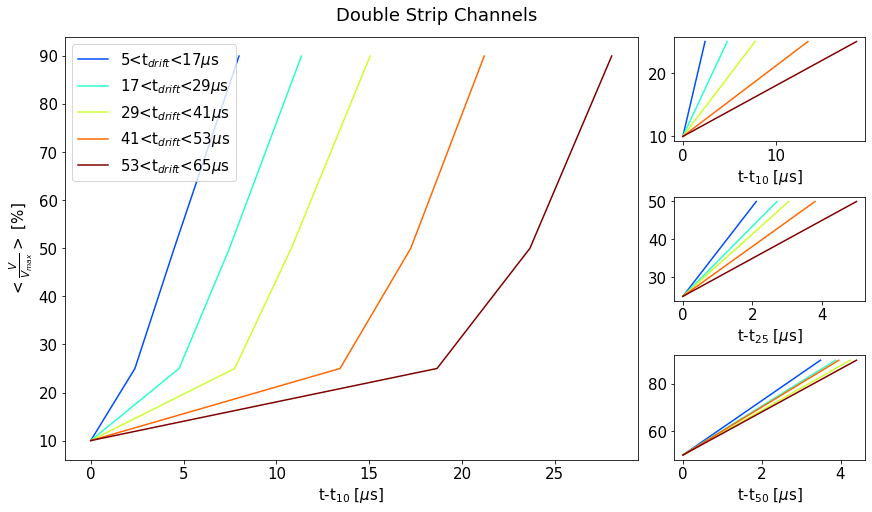

In [46]:
rise_time1025 = []
rise_time2550 = []
rise_time5090 = []
ix_list = []
for ch in analysis_config.channel_map['ChannelName'][analysis_config.channel_map['ChannelType'] == 'TileStrip']:
    #if ('-' in ch) or ('/' in ch):
    if not '/' in ch:
        continue
    energy_key = 'TileStrip ' + ch + ' Charge Energy'
    rms_key = 'TileStrip ' + ch + ' Baseline RMS'
    channel_mask = (df_ind[energy_key] > 5*df_ind[rms_key]) &\
    (df_ind['TileStrip '+ch+' T10'] > trigger_time) &\
    (df_ind[energy_key]>0.5)
    rise_time1025.append((df_ind['TileStrip '+ch+' T25'][channel_mask] - df_ind['TileStrip '+ch+' T10'][channel_mask])*\
    sampling_time)
    rise_time2550.append((df_ind['TileStrip '+ch+' T50'][channel_mask] - df_ind['TileStrip '+ch+' T25'][channel_mask])*\
    sampling_time)
    rise_time5090.append((df_ind['TileStrip '+ch+' T90'][channel_mask] - df_ind['TileStrip '+ch+' T50'][channel_mask])*\
    sampling_time)
    ix_list.extend(df_ind[channel_mask].index)
rise_time1025 = pd.concat(rise_time1025,ignore_index=True)
rise_time2550 = pd.concat(rise_time2550,ignore_index=True)
rise_time5090 = pd.concat(rise_time5090,ignore_index=True)

t_slice = 6
drift_range = np.linspace(5,65,t_slice)
fig3 = plt.figure(constrained_layout=True,figsize=(12,7))
gs = fig3.add_gridspec(3, 4)
f3_ax0 = fig3.add_subplot(gs[:, :-1])
f3_ax1 = fig3.add_subplot(gs[0, -1])
f3_ax2 = fig3.add_subplot(gs[1, -1])
f3_ax3 = fig3.add_subplot(gs[2, -1])
colors = plt.cm.jet(np.linspace(0,1,t_slice))
for j,dr in enumerate(drift_range):
    if j == 0:
        continue
    time_slice = np.logical_and(DriftTime_ind[ix_list]>drift_range[j-1],DriftTime_ind[ix_list]<dr)
    y_val = [10.0,25.0,50.0,90.0]
    x_val = [0]
    for v in (rise_time1025[time_slice.to_list()],\
              rise_time2550[time_slice.to_list()],\
              rise_time5090[time_slice.to_list()]):
        x_val.append(np.mean(v))
    f3_ax0.plot(np.cumsum(x_val),y_val,label='{:.0f}<t$_{{drift}}$<{:.0f}$\mu$s'.format(drift_range[j-1],dr),c=colors[j])
    f3_ax1.plot([0,x_val[1]],[10.0,25.0],c=colors[j])
    f3_ax2.plot([0,x_val[2]],[25.0,50.0],c=colors[j])
    f3_ax3.plot([0,x_val[3]],[50.0,90.0],c=colors[j])
f3_ax0.set_xlabel('t-t$_{10}$ [$\mu$s]')
f3_ax1.set_xlabel('t-t$_{10}$ [$\mu$s]')
f3_ax2.set_xlabel('t-t$_{25}$ [$\mu$s]')
f3_ax3.set_xlabel('t-t$_{50}$ [$\mu$s]')
f3_ax0.set_ylabel(r'$<\frac{V}{V_{max}}>$ [%]')
f3_ax0.legend()
fig3.suptitle('Double Strip Channels')
plt.show()

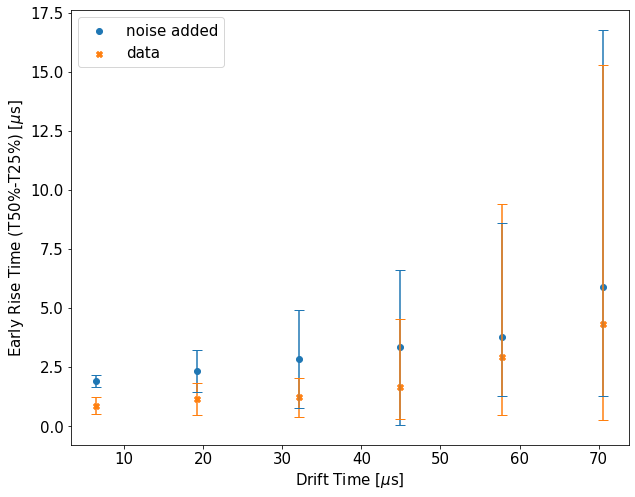

In [68]:
drift_val = [6.416666666666667,
19.25,
32.083333333333336,
44.91666666666667,
57.75,
70.58333333333334]
sim_data_val = [1.9218130311614734,
2.3237133689839577,
2.8488911392405067,
3.340821731748727,
3.7842347629796844,
5.896062992125985]
sim_err_data_val = [
[0.2504026426702625,
0.8914593330273632,
2.0795386089524808,
3.292044885552455,
2.504234762979684,
4.616062992125984],
[0.2504026426702625,
0.8914593330273632,
2.0795386089524808,
3.292044885552455,
4.827237732438009,
10.890793696265423]]
data_val = [0.8715210991167812,
1.1369311475409836,
1.2273586497890296,
1.6454539781591264,
2.9363809523809525,
4.3302564102564105]
err_data_val = [
[0.36206151415980525,
0.6719033291954498,
0.8200507098521278,
1.3574539781591264,
2.4563809523809526,
4.05825641025641],
[0.36206151415980525,
0.6719033291954498,
0.8200507098521278,
2.87784906810667,
6.453021547536513,
10.967917776155609]]
plt.scatter(drift_val,sim_data_val,label='noise added')
plt.scatter(drift_val,data_val,marker='X',label='data')
plt.errorbar(drift_val,sim_data_val,sim_err_data_val,fmt='none', capsize=5)
plt.errorbar(drift_val,data_val,err_data_val,fmt='none', capsize=5)
plt.legend()
plt.xlabel('Drift Time [$\mu$s]')
plt.ylabel('Early Rise Time (T50%-T25%) [$\mu$s]')
plt.show()